<div style="border:solid Chocolate 2px; padding: 40px">

<b> Виталий, привет!👋</b>

Меня зовут Алексей Гриб, и я буду ревьюером твоего проекта. 

Сразу хочу предложить в дальнейшем общаться на "ты" - надеюсь, так будет комфортнее:) Но если это неудобно, обязательно дай знать, и мы придумаем что-нибудь ещё!
    
Цель ревью - не искать ошибки в твоём проекте, а помочь тебе сделать твою работу ещё лучше, устранив недочёты и приблизив её к реальным задачам специалиста по работе с данными. Поэтому не расстраивайся, если что-то не получилось с первого раза - это нормально, и это поможет тебе вырасти!
    
Ты можешь найти мои комментарии, обозначенные <font color='green'>зеленым</font>, <font color='gold'>желтым</font> и <font color='red'>красным</font> цветами, например:

<br/>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> похвала, рекомендации «со звёздочкой», полезные лайфхаки, которые сделают и без того красивое решение ещё более элегантным.
</div>

<br/>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> некритичные ошибки или развивающие рекомендации на будущее. 
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
критичные ошибки, которые обязательно нужно исправить.
</div>

    
Пожалуйста, не удаляй мои комментарии, они будут особенно полезны для нашей работы в случае повторной проверки проекта. 
    
Ты также можешь задавать свои вопросы, реагировать на мои комментарии, делать пометки и пояснения - полная творческая свобода! Но маленькая просьба - пускай они будут отличаться от моих комментариев, это поможет избежать путаницы в нашем общении:)
Например, вот так:
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Привет! Полностью согласен общаться на "ты"! Т.к. комментариев было достаточно много, постарался ответить на все <font color='gold'>желтые</font> и <font color='red'>красные</font>, чтобы впоследствии не запутаться.
</div>
    
Давай посмотрим на твой проект!

# Анализ лояльности пользователей Яндекс Афиши

Команда маркетинга хочет лучше понимать поведение пользователей. Для этого они просят вас провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. Это позволит:


- Быстро выявлять перспективных клиентов и предлагать им персонализированные условия.
- Точно настраивать рекламу на аудитории с высокой вероятностью возврата.
- Оптимизировать маркетинговые бюджеты.
- Повысить общий уровень удержания клиентов.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Хорошее вступление!
    
В нём есть всё, что необходимо, чтобы понять суть проекта с первых строк отчёта!

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Выгрузка данных при помощи SQL

Первоначально установим все библиотеки, используемые в проекте:

In [1]:
!pip install sqlalchemy
!pip install psycopg2
!pip install phik
!pip install python-dotenv

  Using cached psycopg2-2.9.11.tar.gz (379 kB)
    ERROR: Command errored out with exit status 1:
     command: /opt/conda/bin/python3.9 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-9zqd2euj/psycopg2_2c446f3ba2e540a18bc7e1590a16ffc1/setup.py'"'"'; __file__='"'"'/tmp/pip-install-9zqd2euj/psycopg2_2c446f3ba2e540a18bc7e1590a16ffc1/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-i41hh8xs
         cwd: /tmp/pip-install-9zqd2euj/psycopg2_2c446f3ba2e540a18bc7e1590a16ffc1/
    Complete output (23 lines):
    running egg_info
    creating /tmp/pip-pip-egg-info-i41hh8xs/psycopg2.egg-info
    writing /tmp/pip-pip-egg-info-i41hh8xs/psycopg2.egg-info/PKG-INFO
    writing dependency_links to /tmp/pip-

Запустим команду для установки SQLAlchemy и модуля psycopg2. Также импортируем требуемые библиотеки и функцию create_engine() из библиотеки SQLAlchemy для подключения к базе данных и выполнения SQL-запроса:

In [2]:
import sqlalchemy as sa
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
from phik import report
from sqlalchemy import create_engine
import os
import dotenv
from dotenv import load_dotenv

print(f"SQLAlchemy: {sa.__version__}")
print(f"psycopg2: {psycopg2.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {plt.matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"numpy: {np.__version__}")
print(f"phik: {phik.__version__}")

SQLAlchemy: 1.4.15
psycopg2: 2.9.2 (dt dec pq3 ext lo64)
pandas: 1.2.4
matplotlib: 3.3.4
seaborn: 0.11.1
numpy: 1.21.1
phik: 0.12.5


Используем подключение к базе Практикума при помощи .env файла:

In [4]:
#load_dotenv()

#connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
 #   os.getenv('DB_USER'),
  #  os.getenv('DB_PASSWORD'),
   # os.getenv('DB_HOST'),
    #os.getenv('DB_PORT'),
    #os.getenv('DB_NAME')
#)

#engine = create_engine(connection_string)

К базе подключились, теперь можно извлекать результаты SQL-запроса.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Библиотеки импортировали, коннектор сделали - отлично!

In [5]:
query = '''
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,  -- берём из purchases, как указано в схеме
    c.city_name,
    r.region_name
FROM afisha.purchases AS p
JOIN afisha.events AS e
    ON p.event_id = e.event_id
JOIN afisha.city AS c
    ON e.city_id = c.city_id
JOIN afisha.regions AS r
    ON c.region_id = r.region_id
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
''' 

df = pd.read_sql_query(query, con=engine)
display(df)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Глиногорск,Каменевский регион
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Ягодиновка,Широковская область


Выгрузка из базы данных SQL содержит 290611 строк и следующие столбцы:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа;
- `order_ts` — дата и время создания заказа;
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Данные из запроса получены.

---

**Задача 1.2:** Изучение общей информации о выгруженных данных. 

Для вывода общей информации воспользуемся методом `describe()`:

In [6]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

None

По результатам анализа видим, что в данных нет пропусков - кроме тех, которые были созданы нами же в столбце days_since_prev. Впоследствии эти пропуски стоит оставить как есть, ведь они и так дают требуемую информацию.
С типами данных также никаких операций проделывать не надо - они корректны и понижение разрядности в них не требуется. Однако не стоит забывать о том, что данные могут содержать явные (например, заказы, имеющие один и тот же идентификатор, или заказы от одного пользователя в одно и то же время) и неявные (например, неодинаково записанные данные в текстовых столбцах) дубликаты. Также стоит проверить числовые данные на аномальные значения и выбросы - отрицательные или крайне большие выручки с заказов, очень большое количество билетов в заказе, большие перерывы между заказами (больше исследуемого периода времени) и т.д.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Первичный анализ данных выполнен.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Стоит наметить конкретные шаги по обработке данных - буквально всё, что происходит в следующем блоке.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Хорошо. Исправил в текстовом блоке выше.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Учтено.

---

###  2. Предобработка данных

Первым делом проверим данные на явные дубликаты. Таковыми будут являться заказы, совершенные одним пользователем в одно и то же время. Поэтому проверим наличие дубликатов по столбцам user_id и order_ts:

Как было сказано выше, данные в выгруженном датафрейме достаточно структурированны:
- Пропуски присутствуют только в созданном нами столбце, в котором пропуски допустимы и являются индикатором;
- Преобразование данных в столбцах не требуется, как и понижение разряда;

Перед дальнейшими операциями с датафреймом зафиксируем количество его строк:

In [7]:
df_len_before = len(df)
display(df_len_before)

290611

Первым делом проверим данные на явные дубликаты. Таковыми будут являться заказы, совершенные одним ользователем в одно и то же время. Поэтому проверим наличие дубликатов по столбцам user_id и order_ts:

In [8]:
obv_duplicates_1 = df[['user_id', 'order_ts']].duplicated().sum()

display(obv_duplicates_1)
display(round(obv_duplicates_1 / df_len_before * 100, 2))

170

0.06

Также в данных не может быть нескольких заказов с одним идентификатором. Поэтому проверим на дубликаты еще и столбец order_id:

In [9]:
obv_duplicates2 = df['order_id'].duplicated().sum()

display(obv_duplicates2)
display(round(obv_duplicates2 / df_len_before * 100, 2))

0

0.0

Одинаковых идентификаторов заказов не обнаружено - все в порядке!

В данных выявлено 170 явных дубликатов, которые требуется удалить:

In [10]:
df = df.drop_duplicates(subset=['user_id', 'order_ts'])

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Тут в целом может быть ситуация, когда пользователь делает несколько заказов из корзины - в таком случае дубликаты по пользователю и временной метке будут иметь валидную причину.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Стоит также проверить явные дубликаты и дубликаты по `order_id`.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Понял. Перед удалением вставил соответствующие блоки.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Учтено.

Далее проверим наличие в данных неявных дубликатов. Они могут встретиться в текстовых столбцах event_type_main, service_name, city_name и region_name. Проверим каждый из них на уникальные значения:

In [11]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

In [12]:
df = df.sort_values(by = 'service_name')
df['service_name'].unique()

array(['Crazy ticket!', 'Show_ticket', 'Билет по телефону',
       'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки',
       'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка',
       'Вперёд!', 'Выступления.ру', 'Городской дом культуры',
       'Дом культуры', 'Дырокол', 'За билетом!', 'Зе Бест!', 'КарандашРУ',
       'Кино билет', 'Край билетов', 'Лимоны', 'Лови билет!',
       'Лучшие билеты', 'Мир касс', 'Мой билет', 'Облачко', 'Прачечная',
       'Радио ticket', 'Реестр', 'Росбилет', 'Тебе билет!', 'Телебилет',
       'Тех билет', 'Цвет и билет', 'Шоу начинается!', 'Яблоко'],
      dtype=object)

В данном случае потенциальными дубликатами могут являться заказы, сделанные через операторов Городской дом культуры и Дом культуры. Проверим данные, в которых встречаются эти значения в столбце service_name:

In [13]:
dupl = df[df['service_name'].isin(['Городской дом культуры', 'Дом культуры'])].sort_values(by = ['user_id', 'order_ts'])
display(dupl.head(20))

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
45,002ec276eee9b0b,mobile,1635543,2024-07-21,2024-07-21 13:14:01,rub,1308.74,3,0.0,460567,2802fc66-4268-4529-8b4d-35a6a77ac375,концерты,Дом культуры,Глиногорск,Каменевский регион
44,002ec276eee9b0b,mobile,1635572,2024-07-21,2024-07-21 13:17:50,rub,1744.99,4,11.0,460567,2802fc66-4268-4529-8b4d-35a6a77ac375,концерты,Дом культуры,Глиногорск,Каменевский регион
154,009201290d7316b,mobile,5757632,2024-09-19,2024-09-19 10:36:41,rub,461.19,2,9.0,534026,5ac0c8be-1d29-48a2-865a-6658688f8e37,концерты,Городской дом культуры,Озёрск,Североярская область
271,00ef34b0b483ba6,mobile,6281227,2024-10-30,2024-10-30 20:57:13,rub,124.98,1,0.0,11361,64a1d1c9-c17a-4bb8-b8e9-8c91e8d25805,театр,Городской дом культуры,Озёрск,Североярская область
269,00ef34b0b483ba6,mobile,6281314,2024-10-30,2024-10-30 21:01:46,rub,249.97,2,2.0,11361,64a1d1c9-c17a-4bb8-b8e9-8c91e8d25805,театр,Городской дом культуры,Озёрск,Североярская область
270,00ef34b0b483ba6,mobile,6281169,2024-10-30,2024-10-30 21:03:02,rub,124.98,1,0.0,11361,64a1d1c9-c17a-4bb8-b8e9-8c91e8d25805,театр,Городской дом культуры,Озёрск,Североярская область
541,01370a0e9c1a7d5,mobile,5117747,2024-09-18,2024-09-18 15:14:04,rub,333.64,2,2.0,10675,7596bae4-3432-4968-b9a3-dad4cb24fc07,театр,Городской дом культуры,Озёрск,Североярская область
592,01370a0e9c1a7d5,desktop,2078170,2024-10-17,2024-10-17 18:12:17,rub,258.10,5,0.0,201834,457ed08d-a916-4741-931d-45a7b44531bd,театр,Городской дом культуры,Озёрск,Североярская область
664,0159dcb26a3c6f3,mobile,6842754,2024-07-27,2024-07-27 21:30:57,rub,1308.74,3,9.0,460567,2802fc66-4268-4529-8b4d-35a6a77ac375,концерты,Дом культуры,Глиногорск,Каменевский регион
805,019fa401ddb00aa,mobile,7991009,2024-06-09,2024-06-09 12:18:22,rub,613.95,3,1.0,11211,32aaab11-12ea-403b-b2e4-85ff7f280982,театр,Городской дом культуры,Озёрск,Североярская область


В строках дубликаты не обнаружены - значит, это все-таки разные операторы.
Продолжим наше исследование текстовых столбцов:

In [14]:
df = df.sort_values(by = 'city_name')
df['city_name'].unique()

array(['Айкольск', 'Айсуак', 'Акбастау', 'Акбасты', 'Акжолтау',
       'Алтынкала', 'Алтынсай', 'Байкуль', 'Байсары', 'Байтерековск',
       'Беловодск', 'Белоярск', 'Бережанка', 'Бережанск', 'Березиногорск',
       'Березиноск', 'Березовцево', 'Берестовец', 'Берестяград',
       'Берёзиново', 'Берёзовка', 'Берёзогорск', 'Берёзодальн',
       'Берёзополье', 'Берёзореч', 'Берёзоречье', 'Бозарык', 'Боровлянск',
       'Буркиттау', 'Бурьяново', 'Верховино', 'Верховка', 'Верхозолотск',
       'Верхозорье', 'Верхоозёров', 'Ветеринск', 'Вишнёво',
       'Вишнёвогорск', 'Вишнёводск', 'Водниково', 'Глиногорск',
       'Глиногорь', 'Глиноград', 'Глинозолото', 'Глинозорь', 'Глинолес',
       'Глинополин', 'Глинополье', 'Глинополянск', 'Глинореч', 'Глинянск',
       'Голубевск', 'Голубино', 'Гореловск', 'Горицветск', 'Горноград',
       'Горнодолинск', 'Горнолесье', 'Горнолуг', 'Горнополец',
       'Горнополье', 'Горнополянск', 'Горнополяровск', 'Горнополёк',
       'Горноставинск', 'Горяново', '

In [15]:
df = df.sort_values(by = 'region_name')
df['region_name'].unique()

array(['Белоярская область', 'Берестовский округ', 'Берёзовская область',
       'Боровлянский край', 'Верховинская область', 'Верхозёрский край',
       'Верхоречная область', 'Ветренский регион', 'Вишнёвский край',
       'Глиногорская область', 'Голубевский округ',
       'Горицветская область', 'Горноземский регион',
       'Горностепной регион', 'Дальнеземская область',
       'Дальнезорский край', 'Дубравная область', 'Залесский край',
       'Заречная область', 'Зеленоградский округ', 'Златопольский округ',
       'Золотоключевской край', 'Зоринский регион', 'Каменевский регион',
       'Каменичская область', 'Каменноозёрный край', 'Каменноярский край',
       'Каменополянский округ', 'Ключеводский округ',
       'Кристаловская область', 'Кристальная область',
       'Крутоводская область', 'Крутоводский регион', 'Лесноярский край',
       'Лесодальний край', 'Лесополянская область', 'Лесостепной край',
       'Лесоярская область', 'Луговая область', 'Лугоградская область',
    

В данных присутствует некоторое количество похожих наименований округов и областей, но это не говорит о том, что они являются дубликатами. Поэтому неявных дубликатов по данному столбцу нет.

Получается, что по итогам проверки на явные и неявные дубликаты было выявлено и удалено всего 170 строк с ними, что уменьшило датафрейм всего на 0.06% от изначального размера датафрейма.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Категориальные признаки проверены на предмет аномалий.

**Задача 2.1:** Перевод выручки из тенге в рубли (если требуется)

Для удобства дальнейшей работы не лишним будет привести денежные единицы к одной валюте - например, к рублю. Сделать это можно при помощи датафрейма final_tickets_tenge_df.csv. Загрузим его и изучим:

In [16]:
df_money = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
df_money

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


В данном датафрейме приведены курсы тенге к рублю на каждый день 2024 года с 10 января по 31 декабря (всего 357 строк).

Сразу же проверим тип данных в новом датафрейме:

In [17]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


По результатам видим, что потенциальный столбец с датой, по которому в дальнейшем мы будем объединять датафреймы, представлен в некорректном формате object, который требуется перевести в datetime. Сделаем это:

In [18]:
df_money['data'] = pd.to_datetime(df_money['data'])
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


После смены типа данных этот датафрейм мы мождем присоединить к нашему изначальному при помощи левого присоединения. Также после объединения стоит вернуть прежнюю сортировку датафрейма - по возрастанию значений в столбцах user_id и order_dt:

In [19]:
new_df = pd.merge(df, df_money, left_on = 'order_dt', right_on = 'data')
new_df = new_df.sort_values(by = ['user_id', 'order_dt']).reset_index(drop=True)
new_df

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,data,nominal,curs,cdx
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион,2024-08-20,100,18.6972,kzt
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион,2024-07-23,100,18.3419,kzt
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион,2024-10-06,100,19.6475,kzt
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область,2024-07-13,100,18.5010,kzt
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край,2024-10-04,100,19.6648,kzt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290436,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион,2024-10-27,100,19.9266,kzt
290437,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион,2024-10-27,100,19.9266,kzt
290438,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Глиногорск,Каменевский регион,2024-10-30,100,19.9516,kzt
290439,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Ягодиновка,Широковская область,2024-09-24,100,19.3967,kzt


Теперь на основании этого датафрейма мы можем произвести пересчет суммы выручки с тенге в рубли:

In [20]:
# Создаем столбец из курсов по датам:
rate_map = df_money.set_index('data')['curs']

# Используем .map() для "подтягивания" курса в df по дате 'order_dt'
df['rate'] = df['order_dt'].map(rate_map)

# Инициализируем новую колонку значением по умолчанию
df['revenue_rub'] = df['revenue']

# Создаем маску (условие) для строк, которые нужно конвертировать
mask = df['currency_code'] == 'kzt'

# Выполняем векторизированную операцию ТОЛЬКО для нужных строк
df.loc[mask, 'revenue_rub'] = df['revenue'] * df['rate'] / 100  

# Удаляем лишний столбец rate:
df = df.drop('rate', axis=1)

display(df)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,revenue_rub
220541,b7c563717f1906e,mobile,5219189,2024-08-30,2024-08-30 21:28:32,rub,797.64,2,0.0,522779,e1e937b0-a229-490b-b57f-4ef9630d5288,концерты,Яблоко,Акбастау,Белоярская область,797.64
160553,8187dac4be757a0,desktop,593660,2024-10-02,2024-10-02 19:11:32,rub,459.62,3,0.0,418579,b715360e-fb3b-46ec-bf05-13e6e4361593,другое,Билеты без проблем,Акбастау,Белоярская область,459.62
251890,dba80368a42e538,mobile,3258876,2024-08-04,2024-08-04 11:02:57,rub,1196.46,3,22.0,522779,e1e937b0-a229-490b-b57f-4ef9630d5288,концерты,Яблоко,Акбастау,Белоярская область,1196.46
220548,b7c563717f1906e,mobile,5219160,2024-08-30,2024-08-30 21:25:55,rub,797.64,2,0.0,522779,e1e937b0-a229-490b-b57f-4ef9630d5288,концерты,Яблоко,Акбастау,Белоярская область,797.64
165446,86bae757b57e922,mobile,1007664,2024-09-29,2024-09-29 16:31:10,rub,173.81,3,NaN,541929,abe7f74a-5653-4add-ba02-8f377d74bdc1,концерты,Лови билет!,Акбастау,Белоярская область,173.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162757,831ee0f3c55c208,mobile,4392486,2024-09-06,2024-09-06 15:04:07,rub,56.06,4,5.0,524028,86d035c8-c40e-4ae4-ac31-6594cee62c25,другое,Билеты без проблем,Солнечелесье,Яснопольский округ,56.06
4391,02ea4583333f064,mobile,6729712,2024-08-26,2024-08-26 13:46:34,rub,46.19,2,0.0,533411,86d035c8-c40e-4ae4-ac31-6594cee62c25,другое,Билеты без проблем,Байкуль,Яснопольский округ,46.19
257634,e220d45e5e7c67f,mobile,3147806,2024-08-28,2024-08-28 20:24:12,rub,90.79,3,0.0,533402,86d035c8-c40e-4ae4-ac31-6594cee62c25,другое,Билеты без проблем,Зеленогорье,Яснопольский округ,90.79
162758,831ee0f3c55c208,mobile,4392399,2024-09-06,2024-09-06 15:35:40,rub,56.06,4,0.0,524028,86d035c8-c40e-4ae4-ac31-6594cee62c25,другое,Билеты без проблем,Солнечелесье,Яснопольский округ,56.06


In [21]:
#Данный список мы можем присоединить в качестве столбца к нашему исходному датафрейму:

In [22]:
# Добавляем результат в датафрейм
#df['revenue_rub'] = revenue_rub

#display(df)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Выручка приведена к единой валюте.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Некоторые замечания и рекомендации⚠️:</b> 
Использование циклов в `Pandas` - антипаттерн, от которого стоит избавляться: итерирование по строкам может быть ресурсозатратным, особенно если речь о больших таблицах.
    
Лучше использовать маски и присваивание:
        
```python
# Создаем Series (словарь) из курсов: 'data' -> 'curs'
# Это нужно сделать один раз, а не на каждой строке.
rate_map = exchange_rates.set_index('data')['curs']

# Используем .map() для "подтягивания" курса в df по дате 'order_dt'
# Это C-оптимизированная операция, во много раз быстрее apply
df['rate'] = df['order_dt'].map(rate_map)

# Инициализируем новую колонку значением по умолчанию
df['revenue_rub'] = df['revenue']

# Создаем маску (условие) для строк, которые нужно конвертировать
mask = df['currency_code'] == 'kzt'

# Выполняем векторизированную операцию ТОЛЬКО для нужных строк
df.loc[mask, 'revenue_rub'] = df['revenue'] * df['rate'] / 100     
```
        
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
У нас не было особо практических применений этой методики, так что спасибо, что рассказал! Добавил себе в код, закоммитив текстовую част и лишний код (сам цикл удалил, чтоб глаза не мозолил). Возможно, стоило обойтись без присоединения нового датафрейма к исходному - дай пожалуйста комментарий, нужно ли это тоже доработать.
</div>        


<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> С соединением проще и нагляднее.

---

**Задача 2.2:** Анализ данных

Далее произведем работу с численными типами данных. Начнем с очевидного: выручка при продаже не должна быть отрицательной. В связи с этим оценим абсолютное и отнсительное количество строк с отрицательным значением в столбце revenue_rub (если такие будут)

In [23]:
rev_negat_count = len(df[df['revenue_rub'] < 0])
rev_negat_pers = rev_negat_count / len(df) * 100

display(rev_negat_count)
display(rev_negat_pers)

379

0.13049121852631

В данных содержится 379 строка с отрицательными значениями, что составляет менее 0,2% всех данных. Из-за их малого количества и неинформативности их стоит удалить:

In [24]:
df = df[df['revenue_rub'] >= 0]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290062 entries, 220541 to 124509
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290062 non-null  object        
 1   device_type_canonical  290062 non-null  object        
 2   order_id               290062 non-null  int64         
 3   order_dt               290062 non-null  datetime64[ns]
 4   order_ts               290062 non-null  datetime64[ns]
 5   currency_code          290062 non-null  object        
 6   revenue                290062 non-null  float64       
 7   tickets_count          290062 non-null  int64         
 8   days_since_prev        268165 non-null  float64       
 9   event_id               290062 non-null  int64         
 10  event_name             290062 non-null  object        
 11  event_type_main        290062 non-null  object        
 12  service_name           290062 non-null 


Также проверим этот столбец на наличие выбросов: для этого рассчитаем меры размаха и построим диаграмму размаха по этому столбцу:

In [25]:
df['revenue_rub'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    290062.000000
mean        556.410803
std         875.986361
min           0.000000
25%         114.670000
50%         352.270000
75%         802.250000
95%        1631.094500
99%        2628.421739
max       81174.540000
Name: revenue_rub, dtype: float64

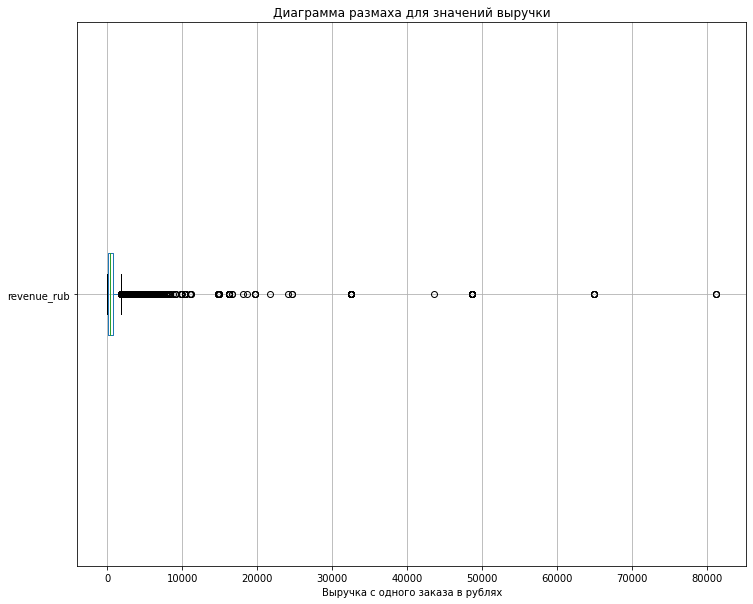

In [26]:
df.boxplot(column='revenue_rub',
           vert=False,
           grid=True,
           figsize=(12, 10))

plt.title('Диаграмма размаха для значений выручки')
plt.xlabel('Выручка с одного заказа в рублях')

plt.show()

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Не забывай оформлять графики - должны быть подписаны оси и названия. Технические комментарии типа `<AxesSubplot:xlabel='datetime'>` стоит убирать - это можно сделать, поставив точку с запятой в последней строке кода в блоке визуализации, либо сделать последней строкой кода этого блока метод `plt.show()`.
    
Тут и далее.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Дописал. Не знаю, честно говоря, как назвать вертикальный столбец в таких случаях - если есть советы, готов послушать.
</div>        


<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> У ящика с усами только одна ось.

По графику достаточно наглядно видно, что в данных этого столбца представлено достаточно большое количество выбросов - даже 99й процентиль на порядок ниже максимального значения.
При такой ситуации также стоит оценить количество таких выбросов:

In [27]:
border = df['revenue_rub'].quantile(0.99)
display(len(df[df['revenue_rub'] > border]))
display(len(df[df['revenue_rub'] > border]) / len(df) * 100)

2824

0.9735849576986989

В столбце revenue_rub менее 1% данных (2824 строк) содержат выбросы, поэтому их также можно удалить:

In [28]:
df = df[df['revenue_rub'] <= border]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287238 entries, 220541 to 124509
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287238 non-null  object        
 1   device_type_canonical  287238 non-null  object        
 2   order_id               287238 non-null  int64         
 3   order_dt               287238 non-null  datetime64[ns]
 4   order_ts               287238 non-null  datetime64[ns]
 5   currency_code          287238 non-null  object        
 6   revenue                287238 non-null  float64       
 7   tickets_count          287238 non-null  int64         
 8   days_since_prev        265538 non-null  float64       
 9   event_id               287238 non-null  int64         
 10  event_name             287238 non-null  object        
 11  event_type_main        287238 non-null  object        
 12  service_name           287238 non-null 

Также интерес представляет столбец tickets_count, содержащий количество билетов в заказе. Для него легитимны все те требования, которые предъявлялись к столбцу revenue_rub - неотриуательность значений и невозможность содержания достаточно большого значения.
Проведем с ним аналогичнные операции:

In [29]:
tickets_negat_count = len(df[df['tickets_count'] < 0])
tickets_negat_pers = tickets_negat_count / len(df) * 100

display(tickets_negat_count)
display(tickets_negat_pers)

0

0.0

Отрицательного количества билетов в заказах не обнаружено - отлично!
Теперь проверим распределение значений в столбце:

In [30]:
df['tickets_count'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    287238.000000
mean          2.741326
std           1.163056
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
95%           5.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64

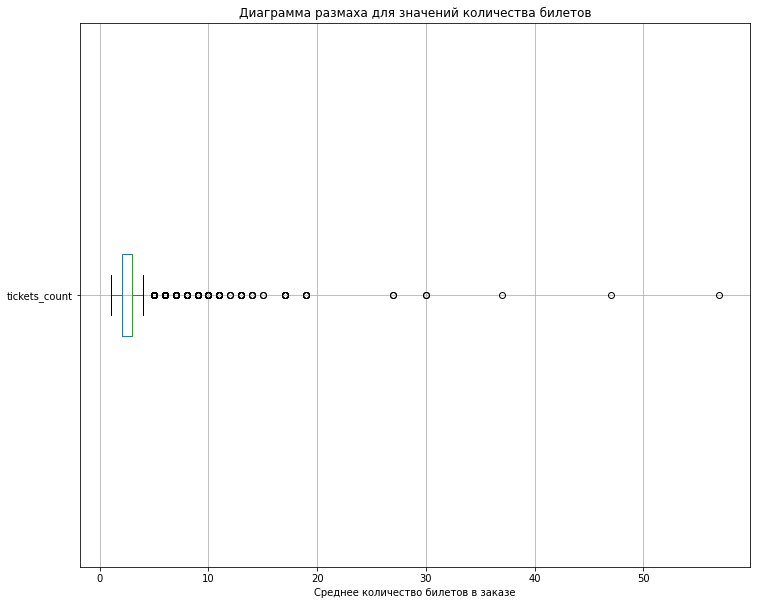

In [31]:
df.boxplot(column='tickets_count',
           vert=False,
           grid=True,
           figsize=(12, 10))

plt.title('Диаграмма размаха для значений количества билетов')
plt.xlabel('Среднее количество билетов в заказе')

plt.show()

Здесь ситуация не столь плачевна - выбросы присутствуют, и некоторые из них даже достаточно велики (около 13 заказов содержали в себе более 10 билетов), но их не так много и они могут быть абсолютно нормальными - например, несколько классов одной школы (или несколько групп одного детского сада) были записаны на один и тот же спектакль, а все билеты покупал один учитель (воспитатель), которому предварительно были сданы деньги.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Численые признаки изучены, удалены выбросы.

Т.к. в процессе предобработки было удалено некоторое количество строк, посчитаем их абсолютное и относительное количество:

In [32]:
df_len_after = len(df)
display(df_len_before - df_len_after)
display((df_len_before - df_len_after) / df_len_before * 100)

3373

1.1606580618077087

Удаление некорретных данных было произведено по 3373 строкам, что составляет 1.2% всех данных в датафрейме, что является незначительным количеством и не должно оказать сильного влияния на последующий исследовательский анализ.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Отлично, что оцениваешь потери в данных после фильтрации.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Создание профиля пользователя:

Для построения пользователя создадим следующие столбцы:

- `user_id` - идентификатор пользователя;
- `first_order_ts` - дата и время первого заказа;
- `last_order_ts` - датa и время последнего заказа;
- `first_order_device` - устройство, с которого был сделан первый заказ;
- `first_order_region` - регион, в котором был сделан первый заказ;
- `first_order_service` - название билетного партнёра, к которому обращались при первом заказе;
- `first_order_event` - жанр первого посещённого мероприятия;
- `total_orders` - общее количество заказов;
- `avg_revenue_rub` - средняя выручка с одного заказа в рублях;
- `avg_tickets_count` - среднее количество билетов в заказе;
- `avg_orders_interval` - среднее время между заказами;
- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

In [33]:
# Создадим пустой датафрейм для создания профиля клиента:
profile = pd.DataFrame()

# Отсортируем датафрейм по времени совершения заказа:
df = df.sort_values(by = ['user_id', 'order_ts'])

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Сортировку важно выполнить по `user_id` и `order_ts`.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Сделано.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Учтено.

In [34]:
# Создаем список уникальных пользователей:
users = df['user_id'].unique()
profile['user_id'] = users
profile = profile.set_index('user_id')

# Определяем дату первого заказа каждого пользователя:
first_order_ts = df.groupby('user_id')['order_ts'].min()
profile['first_order_ts'] = first_order_ts

# Определяем дату последнего заказа каждого пользователя:
last_order_ts = df.groupby('user_id')['order_ts'].max()
profile['last_order_ts'] = last_order_ts

# Определяем для каждого пользователя устройство, с которого он сделал первый заказ:
first_order_device = df.groupby('user_id')['device_type_canonical'].first()
profile['first_order_device'] = first_order_device

# Определяем для каждого пользователя регион, из которого он сделал первый заказ:
first_order_region = df.groupby('user_id')['region_name'].first()
profile['first_order_region'] = first_order_region

# Определяем для каждого пользователя билетного партнера для первого заказа:
first_order_service = df.groupby('user_id')['service_name'].first()
profile['first_order_service'] = first_order_service

# Определяем для каждого пользователя жанр первого посещённого мероприятия:
first_order_event = df.groupby('user_id')['event_type_main'].first()
profile['first_order_event'] = first_order_event

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Некоторые замечания и рекомендации⚠️:</b> Вместо `idxmin` и `idxmax` удобнее использовать `first` и `last` агрегации - ради этого мы и делаем сортировку по пользователю и временной метке.
        
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Использовал в четырех последних, потому что остальные и так смотрятся лаконично.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Учтено.

In [35]:
# Определяем количество заказов каждого пользователя:
total_orders = df.groupby('user_id')['order_ts'].count()
profile['total_orders'] = total_orders

# Определяем среднюю выручку от заказов каждого пользователя в рублях:
avg_revenue_rub = df.groupby('user_id')['revenue_rub'].mean()
profile['avg_revenue_rub'] = avg_revenue_rub

# Определяем среднее количество билетов в заказах каждого пользователя:
avg_tickets_count = df.groupby('user_id')['tickets_count'].mean()
profile['avg_tickets_count'] = avg_tickets_count


#def calc_avg_time_diff(group):
 #  if len(group) > 1:
  #      return group.diff().mean()
  #  return pd.NaT

#avg_orders_interval = df.groupby('user_id')['order_ts'].apply(calc_avg_time_diff)

# Определяем среднее время между заказами каждого пользователя:
avg_orders_interval = df.groupby('user_id')['days_since_prev'].mean()
profile['avg_orders_interval'] = avg_orders_interval

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Разница между событиями уже посчитана в `days_since_prev` - повторно пересчитывать её не нужно.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Согласен, затупил. Исправлено.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Учтено.

In [36]:
# Создание бинарного столбца по количеству заказов (больше/меньше 2х):
is_two = (profile['total_orders'] >= 2).astype(int)
profile['is_two'] = is_two

# Создание бинарного столбца по количеству заказов (больше/меньше 5ти):
is_five = (profile['total_orders'] >= 5).astype(int)
profile['is_five'] = is_five

profile = profile.reset_index()

profile

,user_id,first_order_ts,last_order_ts,first_order_device,first_order_region,first_order_service,first_order_event,total_orders,avg_revenue_rub,avg_tickets_count,avg_orders_interval,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.000,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.000,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,fff13b79bd47d7c,2024-07-16 22:17:10,2024-10-31 18:31:52,mobile,Каменевский регион,Мой билет,другое,9,688.043333,2.555556,13.375,1,1
21834,fff32fc9ad0f9f6,2024-08-15 14:36:28,2024-10-28 23:40:38,desktop,Каменевский регион,Билеты без проблем,стендап,2,850.995000,2.500000,74.000,1,0
21835,fffcd3dde79eb2c,2024-06-20 19:57:25,2024-10-30 13:37:43,desktop,Каменевский регион,Билеты без проблем,концерты,33,557.908485,2.787879,4.125,1,1
21836,fffeeb3c120cf0b,2024-09-24 10:07:42,2024-09-24 10:07:42,desktop,Широковская область,Билеты без проблем,стендап,1,661.530000,2.000000,NaN,0,0


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Профиль пользователя получен, добавлены бинарные признаки.

**Задача 3.2.** Анализ полученного датафрейма

Полученный датафрейм с профилями пользователей содержит данные о 21831 клиенте сервиса. Однако также стоит проверить, какие данные у нас получились.

Для начала посмотрим оуеним общую информацию о датафрейме:

In [37]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21838 entries, 0 to 21837
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              21838 non-null  object        
 1   first_order_ts       21838 non-null  datetime64[ns]
 2   last_order_ts        21838 non-null  datetime64[ns]
 3   first_order_device   21838 non-null  object        
 4   first_order_region   21838 non-null  object        
 5   first_order_service  21838 non-null  object        
 6   first_order_event    21838 non-null  object        
 7   total_orders         21838 non-null  int64         
 8   avg_revenue_rub      21838 non-null  float64       
 9   avg_tickets_count    21838 non-null  float64       
 10  avg_orders_interval  13504 non-null  float64       
 11  is_two               21838 non-null  int64         
 12  is_five              21838 non-null  int64         
dtypes: datetime64[ns](2), float64(3

Сразу стоит отметить, что пропуски в данных содержаться только в столбце avg_orders_interval, который говорит о том, что пользователь сделал только один заказ. Этих пропусков достаточно много, поэтому оценим, какой процент пользователей всего единожды посещал сервис:

In [38]:
users_with_one_order = profile['avg_orders_interval'].isna().sum()

display(users_with_one_order)
display(round(users_with_one_order / len(profile) * 100, 2))
display(100 - round(users_with_one_order / len(profile) * 100, 2))

8334

38.16

61.84

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Некоторые замечания и рекомендации⚠️:</b> Для оценки долей по бинарным признакам удобнее применять `mean`.
        
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Отработал ниже на столбце `is_five`
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Учтено.

Целых 38% пользователей совершили всего один заказ на сервере - достаточно большая текучка. Это также означает, что два и более заказов совершили около 62% пользователей.

Также стоит оценить количество пользователей, которые совершили более 5 заказов в сервисе:

In [39]:
display(profile['is_five'].sum())
display((profile['is_five'].mean() * 100).round(2))

6330

28.99

Процент пользователей с более чем 5ю заказами также немал - 29%, что говорит  достаточно большом количестве постоянных клиентов сервиса.

Также немаловажным показателем работы сервиса являеься средняя выручка с заказов. Посчитаем ее - для этого рассчитаем сначала суммарную выручку для каждого пользователя, а потом усредним значения между пользователями:

In [40]:
#sum_revenue_per_user = profile['avg_revenue_rub'] * profile['total_orders']
avg_revenue_over = profile['avg_revenue_rub'].mean().round(2)

display(avg_revenue_over)

545.03

Средняя выручка с заказа для всех пользователей составляет около 545 рублей, что является достаточно большим показателем (с учетом того, что пользователей и их заказов достаточно много).

Факультатив: альтернативный расчет "в лоб":

In [41]:
# Считаем суммарную выручку для всех пользователей
revenue_sum = (profile['avg_revenue_rub'] * profile['total_orders']).sum()

# Считаем суммарное количество заказов всех пользователей
orders_sum = profile['total_orders'].sum()

# Считаем среднюю выручку с заказов всех пользователей
avg_revenue_over_alt = (revenue_sum / orders_sum).round(2)

display(avg_revenue_over_alt)
display(((avg_revenue_over - avg_revenue_over_alt) / avg_revenue_over * 100).round(2))

518.81

4.81

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Для получения средней выручки с заказа выручку нужно делить на заказы, а не умножать. Тут и далее.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Я перечитал задание и понял, чтто не то считал... Умножение на количество заказов у меня стояло, чтобы посчитать суммарную выручку со всех заказов пользователя. А потом через mean() я считалл среднюю выручку с каждого пользователя.
А по заданию требовалась просто средняя выручка со всех заказов. Так что я просто закоммитил первую строку - так должно быть правильно.
    
В процессе пересчета понял, что можно посчитать прям в лоб. Добавил соответствующие блоки с расчетом, а также вывел расхождение одного метода с другим. Честно, я не могу сам себе уверенно объяснить, какой метод правильнее и точнее. Поясни мне, пожалуйста...
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Оба варианта правильные, но твой - очень длинный.

In [42]:
#Стоит также отметить, что в данных присутствует столбец avg_orders_interval в формате timedelta64, с которым нам придется в дальнейшем работать. Однако такой формат для взаимодействия не особо удобен, поэтому можно перевести данные в нем, например, в дни и представить в виде числа с плавающей точкой (в формате float64):

In [43]:
# Переводим данные интервалов времени в числовые:
#profile['avg_orders_interval'] = (profile['avg_orders_interval'].dt.total_seconds() / 3600 / 24).round(4)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Это преобразование аналогично не требуется.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Согласен, все пофиксилось на этапе создания профилей.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Учтено.


Однако вернемся к изучению данных по таблице. Не лишним будет также посмотреть, каого рода данные представлены в столбцах со средним количеством заказов, средним количеством билетов в заказе и среднему количеству дней между заказами. Исследуем эти столбцы по очереди с использованием мер размаха и диаграмм размаха.

Также, в связи с возможностью удаления аномальных выбросов, зафиксируем перед этим количество строк в датафрейме:

In [44]:
len_profile_before = len(profile)

Начнем со столбца total_orders:

In [45]:
profile['total_orders'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    21838.000000
mean        13.153128
std        121.441002
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
95%         31.000000
99%        152.000000
max      10153.000000
Name: total_orders, dtype: float64

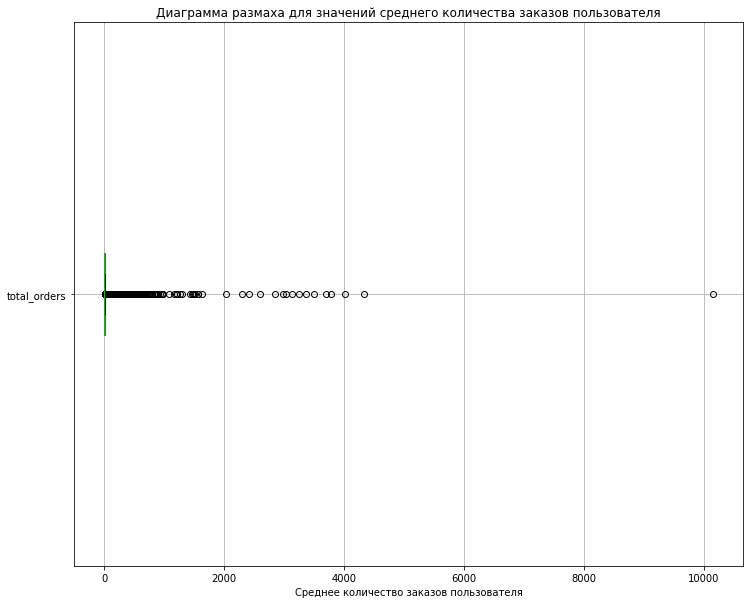

In [46]:
profile.boxplot(column='total_orders',
           vert=False,
           grid=True,
           figsize=(12, 10))

plt.title('Диаграмма размаха для значений среднего количества заказов пользователя')
plt.xlabel('Среднее количество заказов пользователя')

plt.show()

По диаграмме видно, что в данных содержится большое количество выбросов - мало того, что значения 95го и 99го процентилей находятся слишком далеко (31 и 151 заказ соответственно), также существует немалое количество клиентов с количеством заказов свыше 151. Посчитаем их количество:

In [47]:
extra_tickets_count = profile['total_orders'].quantile(0.99)
display(len(profile[profile['total_orders'] > extra_tickets_count]))
display(len(profile[profile['total_orders'] > extra_tickets_count]) / len(profile) * 100)

216

0.9891015660774796

Пользователей, совершивших более 151 заказа за исследуемый период - 218 штук (около 1% всего датафрейма). Если вспомнить, что в датафрейме содержаться данные с июня по октябрь, т.е за 5 месяцев или около 150 дней, стоит отметить, что такие пользователи совершают более одного заказа в день ежедневно! Конечно, в совершении более чем одного заказа в день нет ничего странного - например, вы собрались сходить с друзьями на концерт, один из вас купил билеты на всех, а потом с одним из вас решила пойти девушка, и билеты пришлось докупать. Но чтобы такая ситуация происходила ежедневно - это практически невозможно. Поэтому выбросы по данному показателю свыше 99го процентиля стоит удалить из датафрейма:

In [48]:
profile = profile[profile['total_orders'] <= extra_tickets_count]

Аналогичным образом исследуем столбец avg_tickets_count:

In [49]:
profile['avg_tickets_count'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    21622.000000
mean         2.744254
std          0.917465
min          1.000000
25%          2.000000
50%          2.750000
75%          3.100000
95%          4.000000
99%          5.000000
max         11.000000
Name: avg_tickets_count, dtype: float64

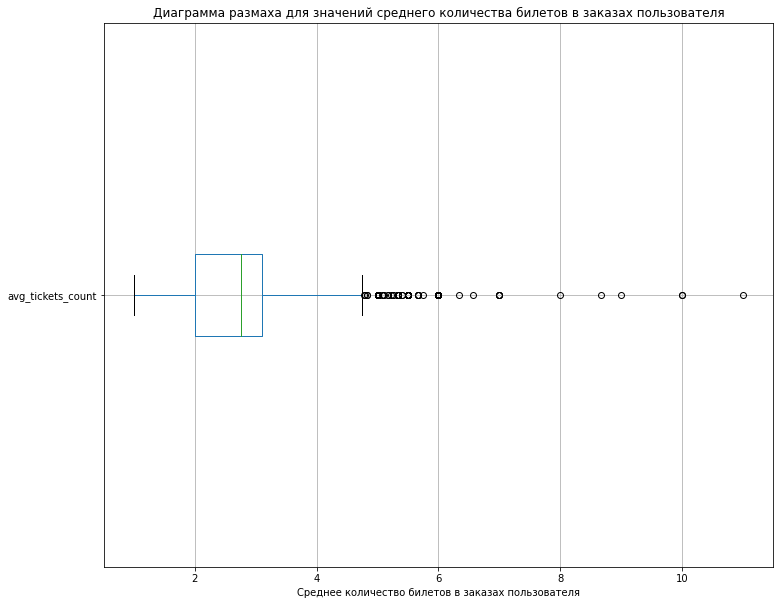

In [50]:
profile.boxplot(column='avg_tickets_count',
           vert=False,
           grid=True,
           figsize=(12, 10))

plt.title('Диаграмма размаха для значений среднего количества билетов в заказах пользователя')
plt.xlabel('Среднее количество билетов в заказах пользователя')

plt.show()

В данном столбце также присутствуют выбросы выше 99го процентиля, однако они не настолько странные - один пользователь вполне может купить более 5 билетов за раз - например, для похода большой компанией на концерт или классом в театр (в таком случае заказ будет оформлять учитель). Так что выбросы в данном столбце стоит оставить.

Последним шагом исследуем данные в столбце avg_orders_interval:

In [51]:
profile['avg_orders_interval'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    13288.000000
mean        16.116685
std         22.423610
min          0.000000
25%          1.333333
50%          8.379808
75%         20.800000
95%         62.000000
99%        113.000000
max        148.000000
Name: avg_orders_interval, dtype: float64

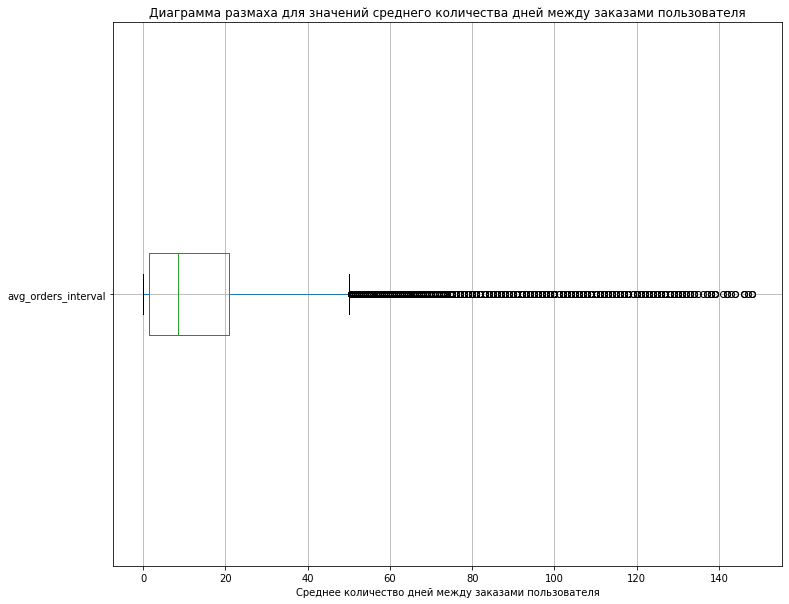

In [52]:
profile.boxplot(column='avg_orders_interval',
          vert=False,
           grid=True,
           figsize=(12, 10))

plt.title('Диаграмма размаха для значений среднего количества дней между заказами пользователя')
plt.xlabel('Среднее количество дней между заказами пользователя')

plt.show()

На основании полученных данных также можно сказать, что выбросы в данном столбце вполне возможны и не являются аномальными - один и тот же клиент вполне может захотеть пойти на мероприятие в начале июня и в конце августа, а перерывы между посещенияи мероприятий одним пользователем вполне могут быть как короткими, так и достаточно длинными. Поэтому выбросы в данном случае также стоит оставить.

По итогам операций с аномальными значениями в данных было удалено всего 218 строк (около 1% всех данных в датафрейме), содержащих аномально большое количество заказов. Данные же, представленныне в столбцах со средним количеством билетов в заказе и среднему количеству дней между заказами также содержат выбросы, однако они не являются аномальными и изменению (удалению) не подлежат.

Также после удаления некоторых строк датафрейма стоит пересчитать характеристики, определенные перед этим - количество пользователей, совершивших менее 2х и более 5ти заказов, а также среднюю выручку за заказ:

In [53]:
users_with_one_order = profile['avg_orders_interval'].isna().sum()

display(users_with_one_order)
display(round(users_with_one_order / len(profile) * 100, 2))
display(100 - round(users_with_one_order / len(profile) * 100, 2))

8334

38.54

61.46

Количество пользователей, совершивших 1 заказ, не изменилось - этого стоило ожидать. А вот их процент относительно всего числа пользователей слегка изменился - с 38,3% до 38,7%.

In [54]:
five_orders_users = profile['is_five'].sum()

display(five_orders_users)
display(round(five_orders_users / len(profile) * 100, 2))

6114

28.28

Количество пользователей с более чем 5ю заказами изменилось, т.к. мы удалили пользователей с аномально большим количеством заказов. Также процентное отношение пользователей с больбшим кол-вом заказов уменьшилось - с 29% до 28,3%

In [55]:
# sum_revenue_per_user = profile['avg_revenue_rub'] * profile['total_orders']
avg_revenue_over = profile['avg_revenue_rub'].mean().round(2)

display(avg_revenue_over)

545.34

А вот средняя выручка с заказа уменьшилась более чем вдвое - с 6800 рублей до 3350 рублей. Это тоже вполне ожидаемо, т.к. удаленные клиенты с аномально большим количеством заказов генерировали и аномально большую прибыль, которая после их удаления более не участвовала в анализе.

Также выведем финальную информацию о датафрейме с профилями пользователей после предобработки:

In [56]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21622 entries, 0 to 21837
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              21622 non-null  object        
 1   first_order_ts       21622 non-null  datetime64[ns]
 2   last_order_ts        21622 non-null  datetime64[ns]
 3   first_order_device   21622 non-null  object        
 4   first_order_region   21622 non-null  object        
 5   first_order_service  21622 non-null  object        
 6   first_order_event    21622 non-null  object        
 7   total_orders         21622 non-null  int64         
 8   avg_revenue_rub      21622 non-null  float64       
 9   avg_tickets_count    21622 non-null  float64       
 10  avg_orders_interval  13288 non-null  float64       
 11  is_two               21622 non-null  int64         
 12  is_five              21622 non-null  int64         
dtypes: datetime64[ns](2), float64(3

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Исследованы статистики по профилю, удалены выбросы.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуем признаки, описывающие первый заказ пользователя, и их влияние на вероятность возвращения пользователя.

**Задача 4.1.1.** Изучим распределение пользователей по признакам.

Для начала оценим, какое мероприятие пользователи чаще всего выбирают для первого заказа. Для этого сгруппируем пользователей по столбцу first_order_event и посчитаем количество пользователей в каждой группе:

In [57]:
users_per_event = profile.groupby('first_order_event')['first_order_ts'].count().sort_values(ascending=False)
users_per_event_pers = (users_per_event / len(profile) * 100).round(2)

display(users_per_event)

first_order_event
концерты    9564
другое      5401
театр       4245
стендап     1110
спорт        794
выставки     413
ёлки          95
Name: first_order_ts, dtype: int64

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Для оценки долей по небинарным признакам удобно использовать `value_counts(normalize=True)`.

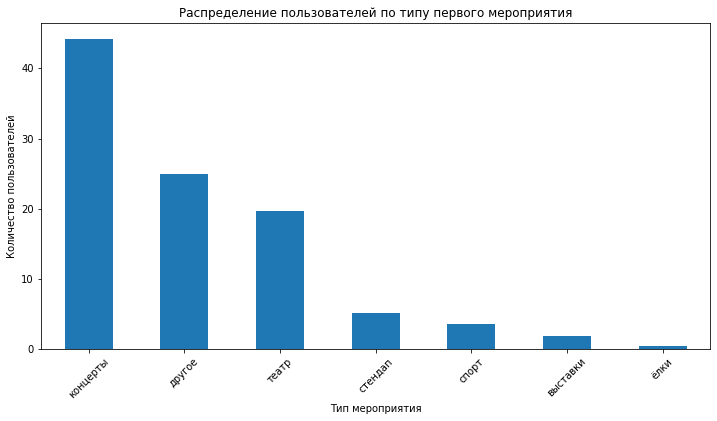

In [58]:
users_per_event_pers.plot(kind='bar',
                    title = 'Распределение пользователей по типу первого мероприятия',
                    xlabel = 'Тип мероприятия',
                    ylabel = 'Количество пользователей',
                    rot =45, 
                    figsize=(12, 6))

plt.show()

Чаще всего в качестве первого мероприятия люди выбирают концерты (более 40% клиентов выбрали именно их), реже - театры (впервые на них пошли примерно 20% человек). Около 6% пользователей выбрали стендап в качестве первого ивента, а менее 6% - спорт, выставки или елки. Стоит также упомянуть категорию "другое", на мероприятия которой пошло около 25% человек - больше, чем на стендап, но сильно меньше, чем на концерт.

Далее оценим распределение пользователей по типам устройств, с котоых они сделали заказ:

In [59]:
users_per_device = profile.groupby('first_order_device')['first_order_ts'].count().sort_values(ascending=False)
users_per_device_pers = (users_per_device / len(profile) * 100).round(2)

display(users_per_device)

first_order_device
mobile     17906
desktop     3716
Name: first_order_ts, dtype: int64

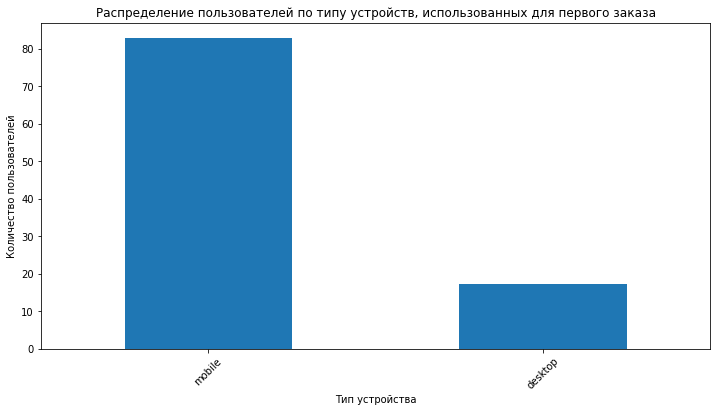

In [60]:
users_per_device_pers.plot(kind='bar',
                    title = 'Распределение пользователей по типу устройств, использованных для первого заказа',
                    xlabel = 'Тип устройства',
                    ylabel = 'Количество пользователей',
                    rot =45, 
                    figsize=(12, 6))

plt.show()

Для первого заказа люди значительно чаще используют мобильные устройства, чем стационарные компьютеры - более 80% пользователей использовали именно смартфон или планшет для первого заказа.

Теперь стоит оценить, а где чаще всего происходят мероприятия, привлекающие людей в сервис. Однако т.к. по предварительному анализу данных в выборке присутствует 81 регион, в выборке стоит оставить только наиболее популярные - например, 10 штук:

In [61]:
users_per_region = profile.groupby('first_order_region')['first_order_ts'].count().sort_values(ascending = False).head(10)
users_per_region_pers = (users_per_region / len(profile) * 100).round(2)

display(users_per_region)

first_order_region
Каменевский регион      7086
Североярская область    3768
Широковская область     1223
Озернинский край         675
Малиновоярский округ     526
Шанырский регион         502
Травяная область         488
Светополянский округ     457
Речиновская область      440
Яблоневская область      411
Name: first_order_ts, dtype: int64

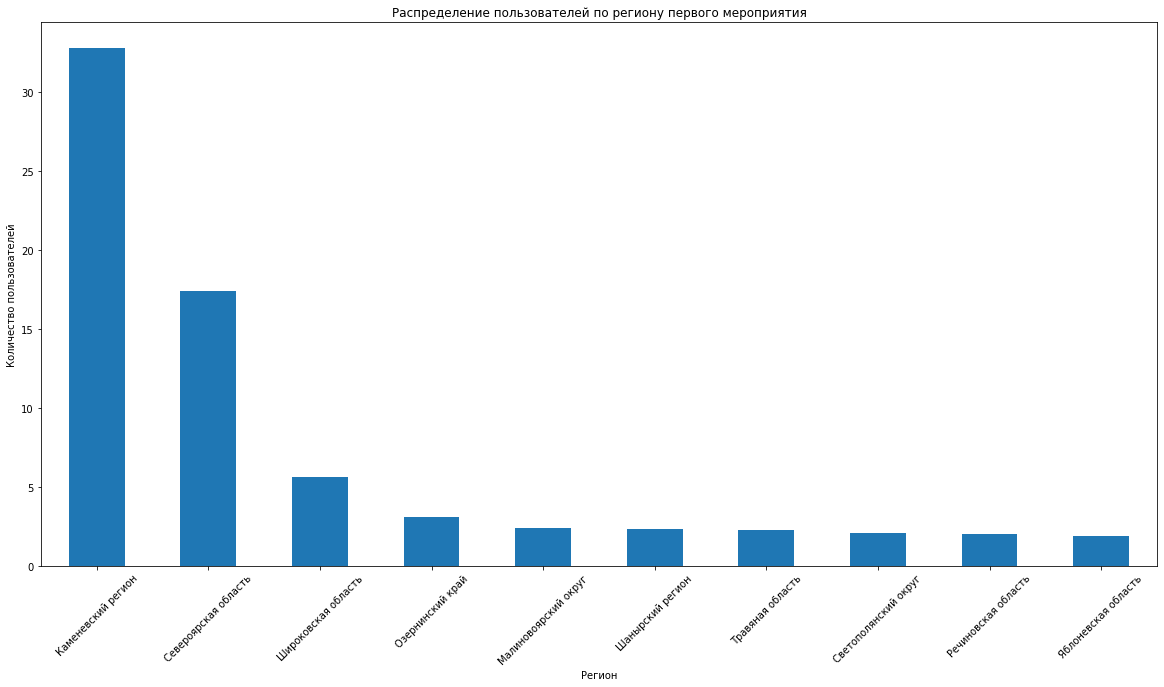

In [62]:
users_per_region_pers.plot(kind='bar',
                           title = 'Распределение пользователей по региону первого мероприятия',
                           xlabel = 'Регион',
                           ylabel = 'Количество пользователей',
                           rot = 45,
                           figsize=(20, 10))

plt.show()

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Для признаков с большим количеством уникальных значений стоит визуализировать топ-n значений по частоте, чтобы график не терял в информативности - сейчас из-за большого скопления значений на оси Х график нечитабелен. Также стоит выполнить сортировку по убыванию, а не возрастанию.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Исправил. Сделал этот и следующий график вертикальными, отсортировал топ-10 и повернул надписи по оси х для читаемости.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Учтено.

Лидерами по данной категории выступает Каменевский регион (примерно 33% пользователей), Североярская область (17% пользователей) и Широковская область (6% пользователей). Остальные регионы не пользуются популярностью - их для первого мероприятия выбрали менее 5% клиентов каждый. 

В данных явно выражены топ-3 региона, однако между ними огромные разрывы - разница между первым и вторым местом составляет 2 раза, а между 2м и 3м - почти 3.

Ну и в конце оценим, какие билетные операторы использовались для покупки первого билета чаще всего (также отберем 10 самых популярных операторов):

In [63]:
users_per_service = profile.groupby('first_order_service')['first_order_ts'].count().sort_values(ascending=False).head(10)
users_per_service_pers = (users_per_service / len(profile) * 100).round(2)

display(users_per_service)

first_order_service
Билеты без проблем    5167
Мой билет             2970
Лови билет!           2812
Билеты в руки         2557
Облачко               2177
Весь в билетах        1286
Лучшие билеты         1182
Прачечная              583
Край билетов           454
Дом культуры           356
Name: first_order_ts, dtype: int64

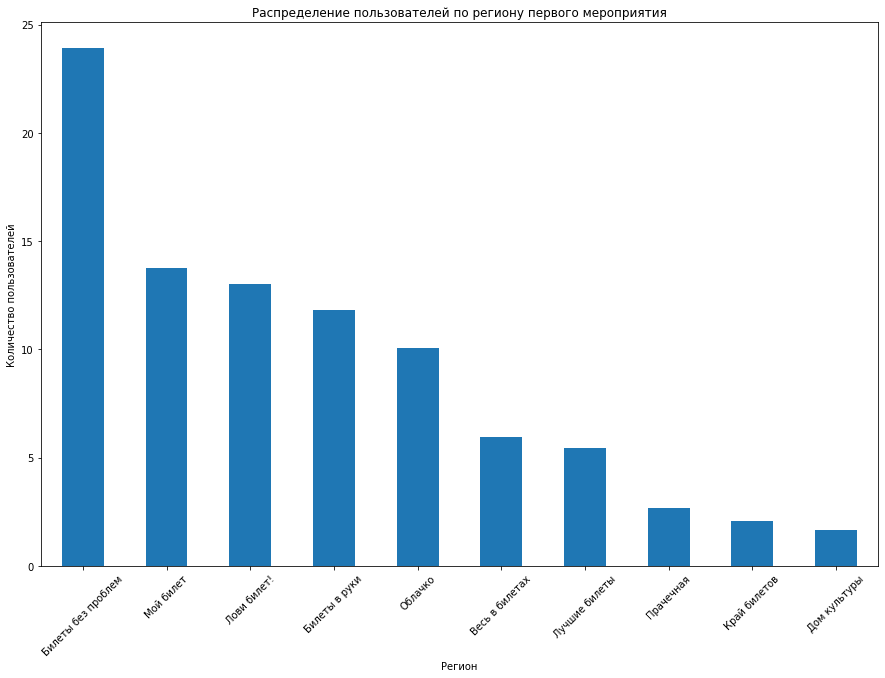

In [64]:
users_per_service_pers.plot(kind='bar',
                            title = 'Распределение пользователей по региону первого мероприятия',
                            xlabel = 'Регион',
                            ylabel = 'Количество пользователей',
                            rot = 45,
                            figsize=(15, 10))

plt.show()

Лидирующее место среди билетных операторов занимает "Билеты без проблем", который использовали для первого заказа 24% пользователей. Примерно 14% использовали "Мой билет", около 12% - "Лови билет!", примерно 11% - "Билеты в руки", а 10% - "Облачко". Около 5% пользователей выбирали для первгого заказа сервисы "Весь в билетах" и "Лучшие билеты". Остальные же сервисы были выбраны менее чем 3% пользователей.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Ты правильно ответил на главный вопрос — распределение во всех случаях неравномерное, и есть выраженные "точки входа". Твой анализ по типу первого мероприятия, типу устройства и билетным операторам выполнен точно. Все лидеры (концерты, mobile, Билеты без проблем) и их процентные доли (40%, 80%, 24% и т.д.) определены верно.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b>  В анализе регионов есть небольшая неточность. Ты утверждаешь, что все остальные регионы, кроме топ-3, выбрали менее 3% клиентов каждый. Это не совсем так: на графике видно, что Озернинский край находится немного выше отметки в 3%.
        
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Заменил значение на 5%. Кстати, раз уж сложилась оказия, спрошу - как принудительно изменить шаг сетки на графике? Чтоб снова с такими процентами впросак не попасть.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Чтобы изменить шаг делений по оси Y в графике, нужно использовать метод `plt.yticks()` или задать пределы и шаг с помощью `plt.gca().yaxis.set_major_locator()`.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:


Теперь посмотрим, а сохраняться ли результаты предыдущего исследования в прежнем виде, если применить их только к тем клиентам, которые совершили 2 и более заказов. Для этого произведем дополнительную группировку по столбцу is_two и повторим предыдущие исследования:

In [65]:
users_per_event_is2 = (profile.groupby('first_order_event')['is_two'].mean() * 100).sort_values(ascending=False)

display(users_per_event_is2)

first_order_event
выставки    64.164649
театр       63.439340
концерты    61.815140
стендап     60.900901
другое      59.563044
спорт       55.793451
ёлки        55.789474
Name: is_two, dtype: float64

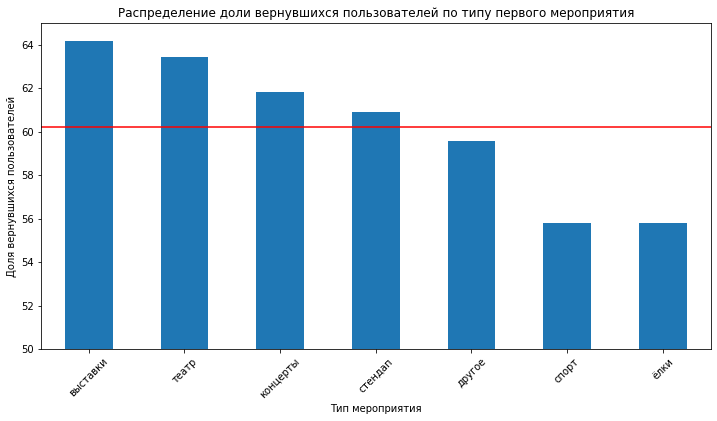

In [66]:
users_per_event_is2.plot(kind='bar',
                    title = 'Распределение доли вернувшихся пользователей по типу первого мероприятия',
                    xlabel = 'Тип мероприятия',
                    ylabel = 'Доля вернувшихся пользователей',
                    rot =45,
                    ylim = [50, 65],
                    figsize=(12, 6))

plt.axhline(y=users_per_event_is2.mean(), color = 'red')
plt.show()

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> На графики этого типа удобно добавить `axhline` со средним уровнем возврата по выборке, чтобы эффективнее находить точки входа.
        
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Воу! А вот это очень удобно! Спасибо, буду использовать почаще!
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Учтено.

Согласно полученной диаграмме, среди тех клиентов, которые в качестве первого мероприятия выбрали посещение театра, около 63,5% совершили повторный заказ. Среди тех, кто впервые пошел на выставку, доля вернувшихся составила около 62.6%, среди посетимвших концерт - 62%, а среди посетивших стендап - 61%. Самые низкие показатели по доле вернувшихся у тех клиентов, кто впервые посетил спортивное мероприятие или елку - таких 56% и 55% соответственно.

Далее проверим долю вернувшихся в разрезе типа устройства, с которого был сделан первый заказ:

In [67]:
users_per_device_is2 = (profile.groupby('first_order_device')['is_two'].mean() * 100).sort_values(ascending=False)

display(users_per_device_is2)

first_order_device
desktop    63.832078
mobile     60.800849
Name: is_two, dtype: float64

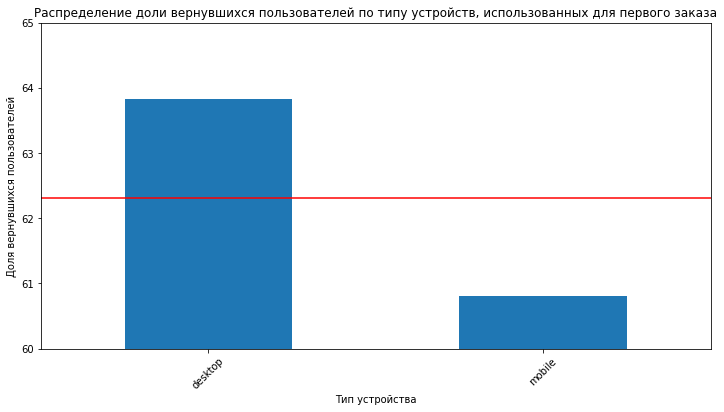

In [68]:
users_per_device_is2.plot(kind='bar',
                    title = 'Распределение доли вернувшихся пользователей по типу устройств, использованных для первого заказа',
                    xlabel = 'Тип устройства',
                    ylabel = 'Доля вернувшихся пользователей',
                    rot =45,
                    ylim = [60, 65],
                    figsize=(12, 6))

plt.axhline(y=users_per_device_is2.mean(), color = 'red')
plt.show()

Видимо, совершать заказ со стационарного компьютера в сервисе проще - для них доля вернувшихся пользователей на 3% выше, чем для мобильных устройств. В абсолютных величинах это, скорее всего, не так (мы помним, насколько сильно больше количество клиентов, совершивших первый заказ с телефона), однако процентное соотношение таково.

Далее исследуем динамику доли вернувшихся пользователей в разрезе региона мероприятия из первого заказа. Т.к. в предыдущей задаче регионов было слишком много, оставим только 10 самых популярных, и финальную фильтрацию также произведем в этом же порядке:

In [69]:
top_10_regions = profile.groupby('first_order_region')['first_order_ts'].count()
top_10_regions = top_10_regions.sort_values(ascending=False).head(10)

users_per_region_is2 = (profile[profile['first_order_region'].isin(top_10_regions.index)]
                        .groupby('first_order_region')['is_two'].mean() * 100).reindex(top_10_regions.index)

display(users_per_region_is2)

first_order_region
Каменевский регион      62.390629
Североярская область    63.826964
Широковская область     64.431725
Озернинский край        55.259259
Малиновоярский округ    55.893536
Шанырский регион        67.330677
Травяная область        61.475410
Светополянский округ    65.645514
Речиновская область     63.409091
Яблоневская область     59.367397
Name: is_two, dtype: float64

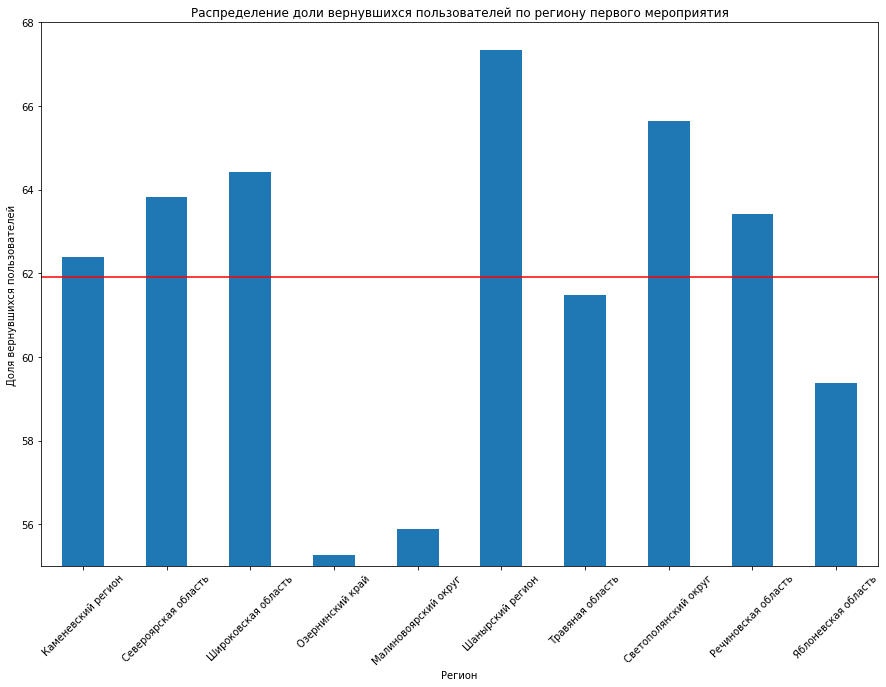

In [70]:
users_per_region_is2.plot(kind='bar',
                          title = 'Распределение доли вернувшихся пользователей по региону первого мероприятия',
                          xlabel = 'Регион',
                          ylabel = 'Доля вернувшихся пользователей',
                          ylim = [55, 68],
                          rot = 45,
                          figsize=(15, 10))

plt.axhline(y=users_per_region_is2.mean(), color = 'red')
plt.show()

Благодаря тому, что регионы сгруппированы так же, как в прошлом исследовании (по убыванию популярности среди пользователей для первого заказа) хотелось бы оценить и динамику изменения доли вернувшихся пользователей для такого отображения. Но по графику общую тенденцию проследить трудно: да, для топ-3 регионов для первого заказа зависимость обратная - с уменьшением популярности доля вернувшихся пользователей растет - но для остальных регионов из топ-10 такую же зависисмость проследить сложно.

Однако стоит отметить, что для всех регионов в данном списке доля вернувшихся пользователей выше, чем доля тех, кто совершил заказ всего единожды - для всех регионов доля превышает 55%.

В конце исследуем динамику доли вернувшихся пользователей в разрезе сервиса по продаже билетов первого заказа. При этом, также как и в прошлом случае, оставим только топ-10 самых популярных агрегаторов и финальную фильтрацию также произведем в этом же порядке:

In [71]:
top_10_services = profile.groupby('first_order_service')['first_order_ts'].count()
top_10_services = top_10_services.sort_values(ascending=False).head(10)

users_per_service_is2 = (profile[profile['first_order_service'].isin(top_10_services.index)]
                        .groupby('first_order_service')['is_two'].mean() * 100).reindex(top_10_services.index)

display(users_per_service_is2)

first_order_service
Билеты без проблем    60.325140
Мой билет             60.875421
Лови билет!           60.953058
Билеты в руки         62.768870
Облачко               61.231052
Весь в билетах        62.908243
Лучшие билеты         61.336717
Прачечная             62.607204
Край билетов          65.198238
Дом культуры          64.606742
Name: is_two, dtype: float64

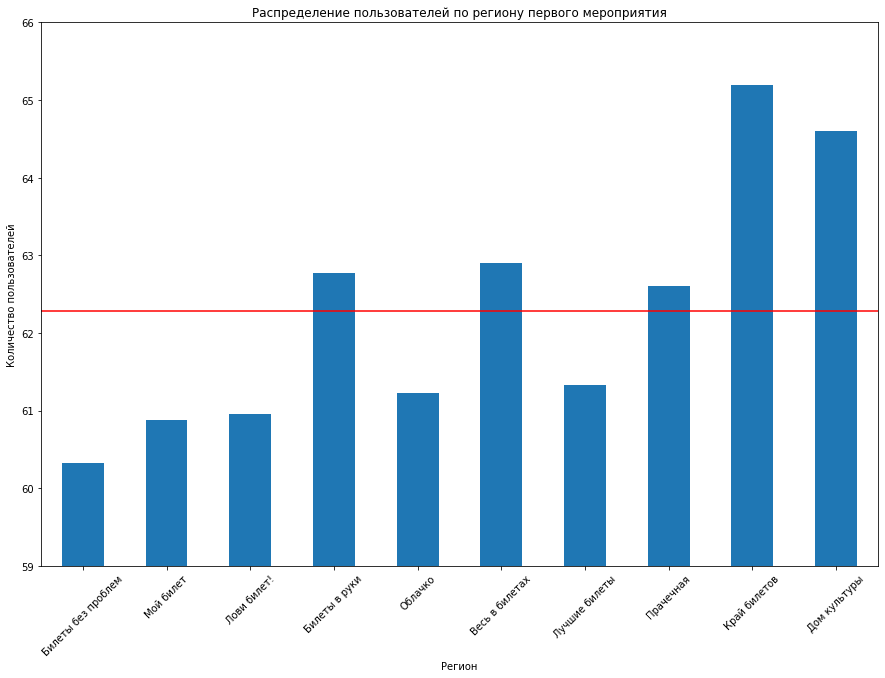

In [72]:
users_per_service_is2.plot(kind='bar',
                           title = 'Распределение пользователей по региону первого мероприятия',
                           xlabel = 'Регион',
                           ylabel = 'Количество пользователей',
                           rot = 45,
                           ylim = [59, 66],
                           figsize=(15, 10))

plt.axhline(y=users_per_service_is2.mean(), color = 'red')
plt.show()

Так же, как и в прошлом исследовании, нельзя однозначно оценить динамику изменения доли вернувшихся пользователей в зависимости от сайта продажи билетов для первого мероприятия пользователя.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Твой анализ по типам мероприятий выполнен отлично. Все цифры (63.5% для театра, 62.6% для выставок, 62% для концертов и т.д.) в точности соответствуют данным на графике. Анализ по типам устройств также проведен очень хорошо. Ты верно определил, что у пользователей, пришедших с desktop, доля возврата выше (примерно на 3%), и при этом правильно учел, что в абсолютных числах мобильная аудитория гораздо больше.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Вывод по билетным операторам выглядит как слабая генерализация. Ты говоришь, что с уменьшением числа пользователей доля вернувшихся растет. Глядя на данные, эта тенденция не такая уж и очевидная. Например, у крупнейших операторов (Билеты без проблем, Мой билет, Лови билет) действительно одни из самых низких долей возврата (60-61%), но и у многих операторов поменьше доли возврата находятся на том же уровне.
        
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Согласен. Удалил фразу про общую тенденцию.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Учтено.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> В анализе регионов допущены ошибки. 
    
Во-первых, ты пишешь, что наблюдается "обратная пропорциональность" (чем меньше заказов, тем выше доля возврата). Это не так. Хотя у топ-3 регионов (Каменевский, Североярская, Широковская) возврат действительно немного растет, у регионов поменьше, таких как Озернинский край и Малиновоярский округ, доля возврата (54.8% и 56.5%) ниже, чем у лидеров.

Во-вторых, ты заявляешь, что "для всех регионов" доля возврата "превышает 59%". Это тоже неверно. В той же таблице видно, что Озернинский край (54.8%) и Малиновоярский округ (56.5%) показывают результат значительно ниже 59%.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Переписал выводы по каждому из спорных пунктов.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Учтено.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Данные гипотезы были проверены выше:
- Гипотеза 1 неверна: тип мероприятия действительно влияет на долю вернувшихся пользователей (например, для относительно небольшого количества пользователей с первым мероприятием типа "выставки" можно отметить достаточно большое количество повторных заказов, а для типов-лидеров по количеству пользователей - "концерт" и "театр" доля вернувшихся пользователей также велика - более 60%), но спортивные мероприятия при этом не являются лидерами по этому показателю - для них изначально было небольшое количество пользователей, совершивших 1й заказ, а доля вернувшихся пользователей составляет 56%, что все еще больше половины, но меньше, чем у многих других категорий (кроме категории "елки", которая находится на последнем месте по обеим выборкам).

- Гипотеза 2 также не может быть оценена однозначно: по построенным графикам нельзя однозначно сказать, что такая тенденция прослеживается. Линейно-положительной или линейно-отрицательной зависимости в доле вернувшихся пользователей не обнаружено.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Твой вывод по второй гипотезе, о том, что нет однозначной линейной связи между размером региона и долей возвратов, является верным и хорошо аргументирован.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> В выводе к первой гипотезе есть грубая ошибка. Ты начинаешь с того, что гипотеза "верна в абсолюте". Это неверно. Гипотеза (что спорт возвращается чаще концертов) прямо опровергается твоими же данными (56% у спорта против >60% у концертов). Твой собственный анализ показывает, что гипотеза не подтвердилась.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Под словами "...верна в абсолюте..." я имел в виду, что тип мероприятия действительно влияет, но тип "спорт" при этом не в лидерах. Переписал более обтекаемо.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Учтено.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучим количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Попробуем проследить связь между средней выручкой сервиса с заказа и повторными заказами. Для этого построим гистограмму распределения выручки для вернувшихся и невернувшихся пользователей:

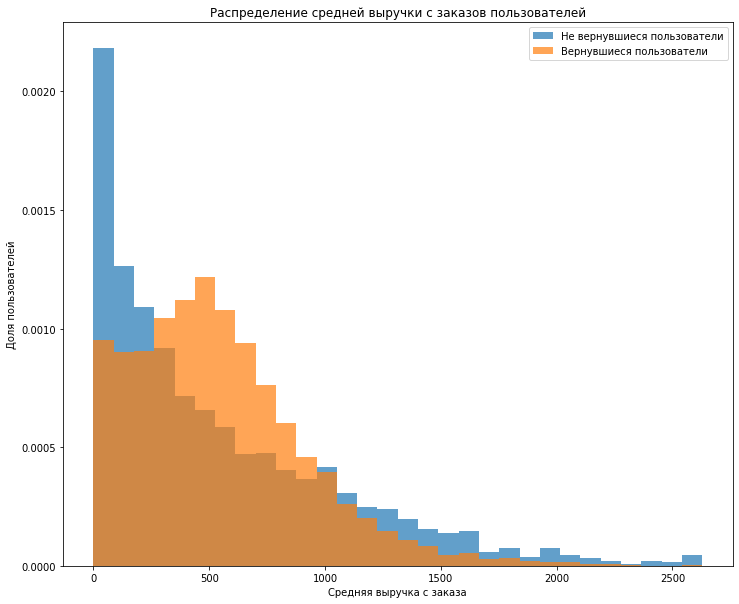

In [73]:
profile.groupby('is_two')['avg_revenue_rub'].plot(kind = 'hist',
                                                          bins = 30,
                                                          legend = True,
                                                          alpha = 0.7,
                                                          density = True,
                                                          figsize = (12, 10))

plt.title('Распределение средней выручки с заказов пользователей')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Доля пользователей')
plt.legend(['Не вернувшиеся пользователи', 'Вернувшиеся пользователи'])

plt.show()

Распределение пользователей по средней выручке с заказа в зависимости от количества заказов происходит неравномерно: для тех пользователей, кто совершил всего один заказ в сервисе, заметна наспадающая характеристика - больше всего пользователей принесли сервису выручку всего около 100 рублей, выручку около 200 рублей принесло меньшее количество, около 300 рублей - еще меньшее и т.д. по нисходящей. Для вернувшихся пользователей картина слегка иная - самым популярным значением выручки является около 600 рублей с заказа. При этом данное значение достаточно стремительно растет, но также быстро и снижается. Также стоит отметить, что в области больших значений выручки (более 800 рублей с заказа) количество клиентов, которые воспользовались сервисом единожды, на каждом интервале превышает количество вернувшихся пользователей.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Твой анализ выполнен безупречно. Ты построил наглядную гистограмму, которая четко отвечает на вопросы, поставленные в задаче. Все твои выводы в тексте полностью соответствуют данным на графике. Ты правильно определил, что у пользователей с одним заказом концентрация выручки находится в самом низком диапазоне (около 100 рублей), в то время как у вернувшихся пользователей пик смещен вправо, в район 600 рублей. Твое наблюдение о том, что в "хвосте" распределения (среди клиентов с очень высокой выручкой) доля пользователей с одним заказом выше, также абсолютно верное.

---

**Задача 4.2.2.** Далее проведем аналогичное исследование только для вернувшихся пользователей и разделим их на группы в зависимотсти от значения в столбце is_five:

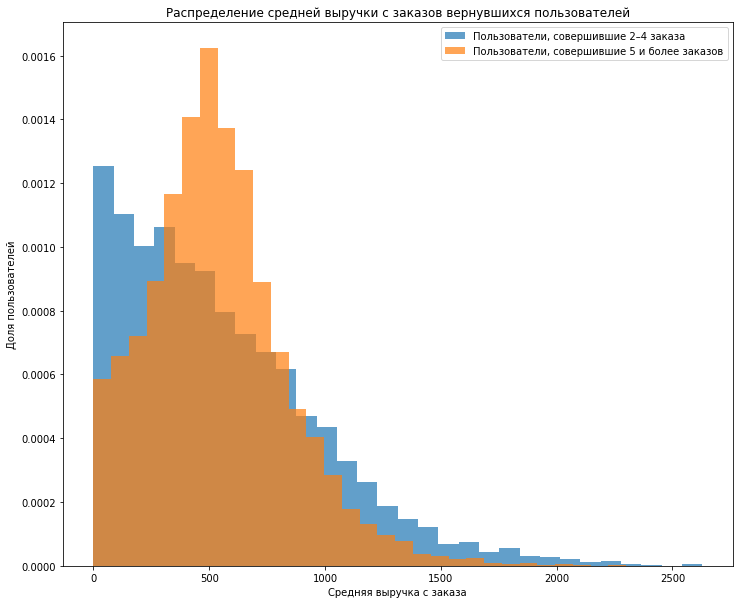

In [74]:
profile[profile['is_two'] == 1].groupby('is_five')['avg_revenue_rub'].plot(kind = 'hist',
                                                                            bins = 30,
                                                                            legend = True,
                                                                            alpha = 0.7,
                                                                            density = True,
                                                                            figsize = (12, 10))
plt.title('Распределение средней выручки с заказов вернувшихся пользователей')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Доля пользователей')
plt.legend(['Пользователи, совершившие 2–4 заказа', 'Пользователи, совершившие 5 и более заказов'])

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Тут нужно или явно делать фильтрацию по числу заказов на пользователя, или делить по флагам:
    
- is_two = True и is_five = False - это 2-4 заказа;
- is_five = True - это 5+ заказов.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Так я же буквально сделал так, как сказано в "делении по флагам"... Сначала я отсеял пользователей с 1 заказом по is_two ==1, а потом в зависимости от значения is_five разделил на категории... В чем я неправ???
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Да, ты прав, я что-то не сообразил течение решения.

При исследовании пользователей с такой группировкой становится достаточно заметной разница между ними. Если говорить о пользователях, совершивших 2-4 заказа, для них наиболее характерны небольшие значения средней выручки - распределение средней выручки с заказа не имеет ярко выраженного пика и имеет плато в диапазонах средней выручки от 200 до 500 рублей. Дальнейшее снижение доли пользователей идет плавно, без стремительных провалов.

Если же говорить о пользователях с большим количеством заказов, для них явнее видно наиболее часто встречающееся значениесредней выручки - оно составляет 500-600 рублей с клиента. При этом характер изменения для таких пользователей менее размеренный - с увеличением средней выручки доля пользователей для каждого из интервалов сначала стремительно растет, достигая описанного выше пика, а потом также стремительно и снижается. Причем так же, как и в прошлом исследовании, стоит отметить, среди пользователей, совершивших меньшее количество заказов, больше доля тех, кто принес порталу большие выручки, чем среди тех пользователей, кто совершил больше заказов (для значений средней выручки более 800 рублей с пользователя в каждом интервале доля пользователей с 2-4 заказами больше, чем доля пользователей с 5 и более заказами).

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

Для этого разобьем пользователей на группы в зависимости от количества билетов в заказе следующим образом:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов
и определим для каждой категории количество человек в ней и долю вернувшихся пользователей:

In [75]:
# Задаем граничные условия для группировки пользователей:
bins = [1, 2, 3, 5, float('inf')]

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Интервалы распределены неверно:
    
- от 1 до 2 билетов - это [1, 2);
- от 2 до 3 билетов - это [2, 3);
- от 3 до 5 билетов - это [3, 5);
- от 5 и более билетов - это [5, ...).
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
По заданию, кстати, не особо понятно, какая скобка должна быть квадатной... Заменил в коде ниже nclude_lowest=True на right=True. Вроде теперь правильно.
    
Но хотелось бы, чтобы задание написали более ясно...
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Обычно "до" всегда невключительно, а "по" - включительно.

In [76]:
profile_copy = profile.copy()

# Создаем столбец с группами
profile_copy['tickets_group'] = pd.cut(profile['avg_tickets_count'], 
                                       bins=bins, 
                                 #include_lowest=True
                                       right=True)

# Группируем по созданным группам
grouped = profile_copy.groupby('tickets_group').agg(
    user_count=('avg_revenue_rub', 'count'),
    is_two_count=('is_two', 'sum'),
    is_two_mean=('is_two', lambda x: round(x.mean() * 100, 2))).reset_index()

print(grouped)

  tickets_group  user_count  is_two_count  is_two_mean
0    (1.0, 2.0]        4816          2308        47.92
1    (2.0, 3.0]        9920          7366        74.25
2    (3.0, 5.0]        5357          3362        62.76
3    (5.0, inf]         194            63        32.47


По среднему количеству билетов в заказе пользователи распределены следующим образом: наибольшее количество пользователей покупает в среднем от 2х до 3х билетов за раз, меньшее количество - от 1 до 2, примерно такое же, но слегка меньше - от 3 до 5, и единицы покупают более 5 бтлетов в среднем. Распределение же вернувшихся пользователей слегка иное - чаще всего повторный заказ делают пользователи из 2й (у которых в среднем от 2 до 3 билетов в заказе) и 3й (у которых в среднем от 3 до 5 билетов в заказе) групп - среди таких пользовыателей вернулись 73,2% и 62.5% соответственно. Среди остальных пользователей доля вернувшихся невелика - 48% для пользователей с 1-2 заказами в среднем и 32,5% для пользователей с более чем 5 заказами.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Тут нужно будет актуализировать.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Общая тенденция не сильно изменилась, но циферки пришлось поправить.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Учтено.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируем влияние дня недели, в которой была совершена первая покупка, на поведение пользователей. Для этого выделим день недели из даты первого заказа и посчитаем для каждого общее число пользователей и долю пользователей, совершивших повторные заказы:

In [77]:
profile_copy = profile.copy()

# Создаем дополнительный столбец с днем недели, в который был совершен 1й заказ:
profile_copy['first_order_weekday'] = profile_copy['first_order_ts'].dt.weekday

# Группируем датафрейм по добавленному столбцу:
weekday_groups = profile_copy.groupby('first_order_weekday').agg(
    user_count=('first_order_ts', 'count'),
    is_two_mean=('is_two', lambda x: round(x.mean() * 100, 2)))

display(weekday_groups)

,user_count,is_two_mean
first_order_weekday,,
0,2918,62.99
1,3175,61.89
2,3061,62.27
3,3112,59.45
4,3256,59.77
5,3323,62.77
6,2777,60.06


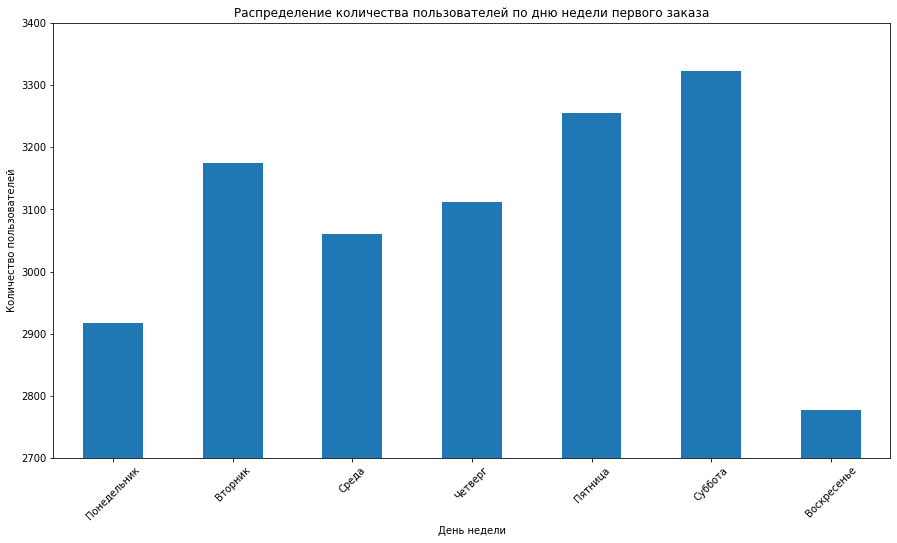

In [78]:
weekday_groups['user_count'].plot(kind='bar',
                    title = 'Распределение количества пользователей по дню недели первого заказа',
                    xlabel = 'День недели',
                    ylabel = 'Количество пользователей',
                    ylim = [2700, 3400],
                    rot = 45,
                    figsize=(15, 8))

new_labels = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
plt.xticks(range(len(new_labels)), new_labels)
plt.show()

Чаще всего люди выбирают для первого заказа субботу (3300 пользователей), пятницу (3250 пользователей) и вторник (3200 пользователей). Это достаточно понятно и легко объяснимо - в пятницу и субботу у людей достаточно свободного времени (из-за сокращенного дня на работе, например, а суббота часто выделяется для встреч с друзьями и выполнения разных дел - для того, чтобы в субботу спокойно отдыхать), а во вторник спадает рабочий понедельничный ажиотаж и можно обсудить мероприятия с коллегами. По этим же причинам самое низкое количество первых заказов выпадает на понедельник (2900 пользователей) и воскресенье (2800 пользователей).

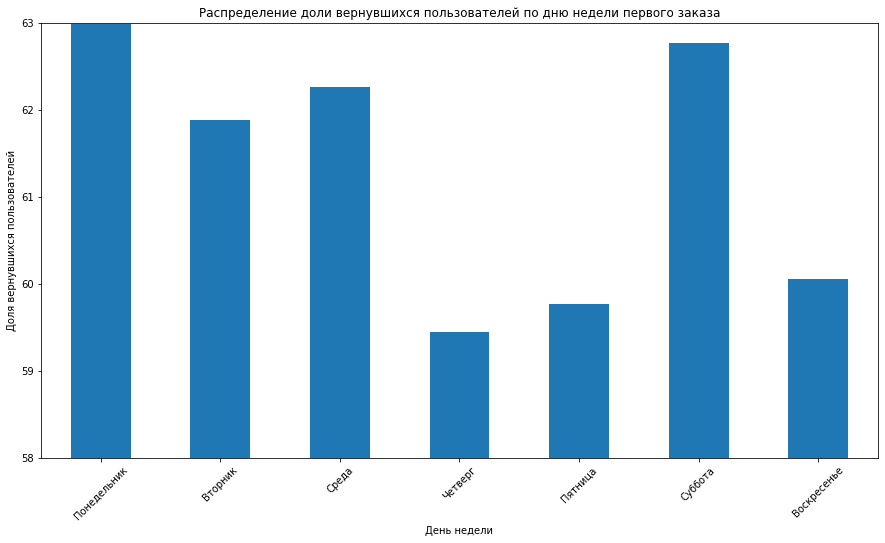

In [79]:
weekday_groups['is_two_mean'].plot(kind='bar',
                    title = 'Распределение доли вернувшихся пользователей по дню недели первого заказа',
                    xlabel = 'День недели',
                    ylabel = 'Доля вернувшихся пользователей',
                    ylim = [58, 63],
                    rot = 45,
                    figsize=(15, 8))

new_labels = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
plt.xticks(range(len(new_labels)), new_labels)
plt.show()

Распределение доли вернувшихся пользователей по дню первого заказа претерпело некоторые изменения относительно предыдущей метрики. Да, среди пользователей, совершивших заказы в субботу и вторник, доля вернувшихся пользователей велика (62.7% и 62.2% соответственно), а вот для пользователей, совершивших первый заказ в пятницу, доля вернувшихся невелика - всего 59.9%. Это может говорить о том, что первыйзаказ в пятницу пользовватели делают стихийно, на эмоциях, и повторно на сервис не возвращаются.

Также стоит отметить понедельник - для сравнительно небольшого количества пользователей, выбравших этот день для первого заказа, доля вернувшихся среди них наибольшая - 63.1%. Возможно, эти люди взяли себе за правило в начале недели заходитьт на портал и подыскивать себе возможность приятного проведения вечера или выходного.

Резюмируя исследование - день недели, в который была сделана первая покупка, не оказывает сильного влияния на возврат клиентов, т.к. вне зависимости от общего количества пользователей, оформивших билеты в определенный день, разница между максимальной и минимальной долями вернувшихся пользователей не превышает 5%.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Твой анализ точно разделен на две части: сначала ты рассматриваешь общее число пользователей, а затем - долю вернувшихся. Все цифры, которые ты приводишь в выводах (например, 3300 пользователей в субботу, 2800 в воскресенье, а также 62.7% возврата для субботы и 63.1% для понедельника), полностью соответствуют данным из таблицы, с учетом разумного округления.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Твой анализ - это очень точное описание данных. Однако он не содержит прямого ответа на главный вопрос из задачи: влияет ли день недели... на вероятность возврата клиента? Ты привел все цифры, но не сделал итогового заключения (например, о том, что влияние есть, но оно не очень сильное, так как все значения лежат в узком диапазоне от 59.4% до 63.1%).
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Добавил резюмирующую фразу.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Учтено.

---

**Задача 4.3.2.** Изучим средний интервал между заказами для вернувшихся пользователей. Для этого сгруппируем их по столбцам `is_two` и `is_five` и рассчитаем среднее время между заказами для каждой из групп:

In [80]:
activity_groups = profile[profile['is_two'] == 1].groupby('is_five')['avg_orders_interval'].mean()

display(activity_groups)

is_five
0    21.343772
1     9.909595
Name: avg_orders_interval, dtype: float64

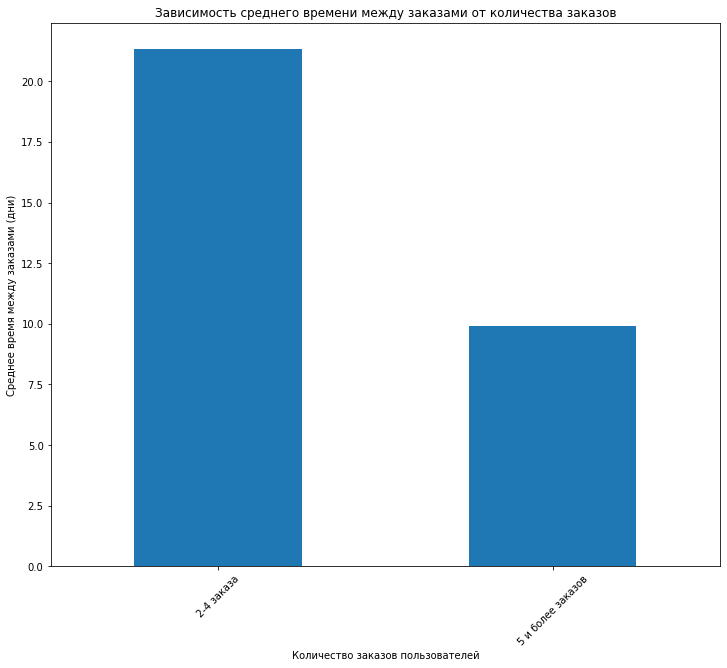

In [81]:
activity_groups.index = ['2-4 заказа', '5 и более заказов']

activity_groups.plot(kind = 'bar',
                     title = 'Зависимость среднего времени между заказами от количества заказов',
                     xlabel = 'Количество заказов пользователей',
                     ylabel = 'Среднее время между заказами (дни)',
                     rot=45,
                     figsize=(12, 10))

plt.show()

Согласно диаграмме, пользователи с бОльшим количеством заказов делают их (в среднем) в 2 раза чаще, т.к. средний интервал между заказами для пользователей с 5ю и более заказами составляет 10 дней против более чем 21 дня для пользователей с 2-4 заказами. Это говорит о том, что пользователи совершающие заказы чаще, совершают их больше, и наоборот - чем больше заказов совершают пользователи, тем чаще они это делают.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучим, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок посредством корреляционного анализа. Для этого построим матрицу корреляции столбца `total_orders` со столбцами `avg_revenue_rub`, `avg_tickets_count` и `avg_orders_interval` (т.к. связь данного столбца со столбцами `is_two` и `is_five` очевидна). При этом используем параметр `interval_cols` для определения интервальных данных:

,total_orders
total_orders,1.000000
avg_orders_interval,0.493496
avg_tickets_count,0.290164
avg_revenue_rub,0.250761


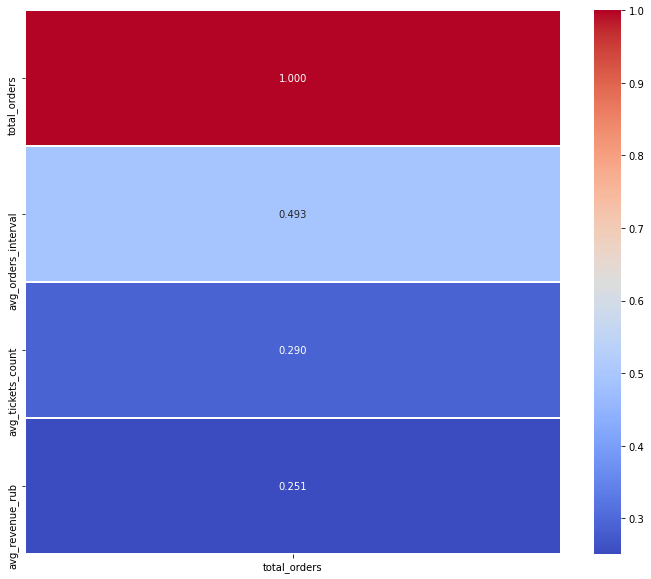

In [82]:
# Числовые и бинарные переменные
corr_col = ['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_orders_interval']

interval_cols = ['avg_revenue_rub', 'avg_tickets_count', 'avg_orders_interval']


matrix = profile[corr_col].phik_matrix(interval_cols=interval_cols)['total_orders'].sort_values(ascending=False).to_frame()

display(matrix)

# Создание тепловой карты:
plt.figure(figsize=(12, 10))

sns.heatmap(data=matrix,
           annot=True,
           cmap='coolwarm',  # Добавляем цветовую схему
           fmt='.3f',         # Формат чисел (3 знака после запятой)
        linewidths=0.5)    # Линии между ячейками

plt.show()

Наилучшую корреляцию столбец total_orders показывает со столбцом avg_orders_interval - как мы выясняли, данные действительно зависят между собой (чем больше заказов в среднем у пользователя, тем меньше время между ними). Корреляция столбца total_orders с остальными также была исследована ранее, но согласно матрице, она менее выраженная, чем со столбцом avg_orders_interval.

Однако посмотрим, останутся ли данные такими же, если пользователи будут разделены по количеству заказов. Для этого углубим исследование, объединив данные в группы по столбцам `is_two` и `is_five` для кждой из категорий:

In [83]:
# Задаем граничные условия для группировки пользователей и названия групп:
bins = [0, 1, 5, float('inf')]
labels = ['1 заказ', '2-4 заказа', '5 заказов и более']

profile_copy = profile.copy()

# Создаем столбец с группами
profile_copy['tickets_group'] = pd.cut(profile['total_orders'], bins=bins, labels=labels, right=False)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Тут аналогично нужно поправить бины.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Поправил.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Учтено.

,2-4 заказа,5 заказов и более
total_orders,1.000000,1.000000
avg_orders_interval,0.334323,0.759735
avg_tickets_count,0.212098,0.000000
avg_revenue_rub,0.159877,0.000000


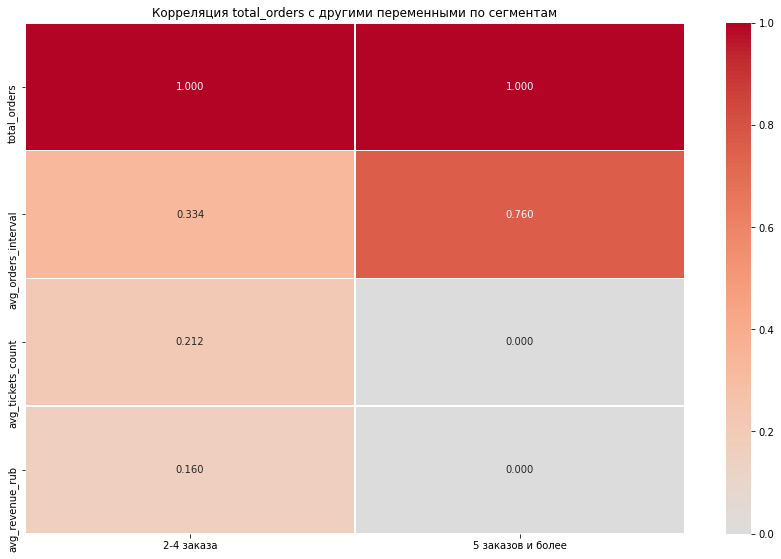

In [84]:
# Числовые и бинарные переменные
corr_col_gr = ['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_orders_interval'
               #, 'tickets_group'
              ]

interval_cols_gr = ['avg_revenue_rub', 'avg_tickets_count', 'avg_orders_interval']

# Создаем объединенную таблицу
combined_corr = pd.DataFrame()

# Строим отдельные матрицы для каждой категории и присоединяем их к объединенной матрице
for segment in labels:
    segment_data = profile_copy[profile_copy['tickets_group'] == segment]
    
    if len(segment_data) > 0:  # Проверяем, что в сегменте есть данные
        # Вычисляем матрицу корреляции:
        matrix_grouped = segment_data[corr_col_gr].phik_matrix(interval_cols=interval_cols_gr)
        # Упорядочиваем данные и строим датафрейм:
        matrix_grouped = matrix_grouped['total_orders'].sort_values(ascending=False).to_frame()
        # Присваиваем столбцам заданные наименования:
        matrix_grouped.columns = [segment]
        # Присоединяем полученный датафрейм к созданному ранее:
        combined_corr = pd.concat([combined_corr, matrix_grouped], axis=1)
        
display(combined_corr)

# Визуализация объединенной матрицы
plt.figure(figsize=(12, 8))
sns.heatmap(data=combined_corr,
           annot=True,
           cmap='coolwarm',
           fmt='.3f',
           linewidths=0.5,
           center=0)
plt.title('Корреляция total_orders с другими переменными по сегментам')
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Обрати внимание на предупреждение:
    
```python
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable tickets_group for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable tickets_group for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable tickets_group for analysis 1. Dropping this column
  warnings.warn(
```
    
Так как признак `tickets_group` с учётом среза принимает одно-единственное значение, корреляцию по нему оценить невозможно - его стоит удалить из выборки при построении матрицы.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Поправил. Анализ переписал. Но у меня пропал анализ для категории "1 заказ", что достаточно странно. Сделал вывод, что категория не коррелирует ни с чем...
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Учтено.

При укрупнении нашего исследования становится видна разница в матрицах корреляции без разделения на группы и с разделением. Например, для группы пользователей с 1 заказом матрица корреляции не построилась, что говорит о том, что в столбце присутствует только одно значение и его корреляциия неопределима ни с чем. Для пользователей с 5 и более заказами наоборот - столбец total_orders коррелирует ТОЛЬКО со столбцом avg_orders_interval, причем достаточно сильно. Столбец total_orders для пользователей с 2-4 заказами показывает корреляцию со всеми столбцами, однако более выражена корреляция со столбцом avg_orders_interval, а для остальных она более слабая.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Ты правильно определил, что в общем (до сегментации) наибольшая связь наблюдается с avg_orders_interval. Твой последующий, более глубокий анализ по сегментам (1 заказ, 2-4 заказа, 5+ заказов) также выполнен абсолютно точно. Все выводы о том, как корреляции меняются внутри групп - например, что у группы 1 заказ нет связи с интервалом, а у группы 5+ заказов это, наоборот, единственная сильная связь - полностью соответствуют данным из таблицы.

### 5. Общий вывод и рекомендации

В ходе разработки проекта были проделаны следующие операции:
1. Выгрузка данных из базы при помощи SQL-запроса и их анализ.
    Т.к. данные и так содержались в достаточно хорошем качестве (практически без пропусков и с корректным типом) их предобработка не потребовалась;
    
2. Предобработка данных:
    2.1. Определение явных дубликатов по столбцам user_id и order_ts: обнаружено и удалено 170 строк (0,06% от всего объема данных в датафрейме);
    2.2. Поиск неявных дубликатов по столбцам event_type_main, service_name, city_name и region_name - неявные дубликаты не были обнаружены;
    2.3. Приведение значений выручки к одной валюте - перевод тенге в рубли по датафрейму final_tickets_tenge_df.csv;
    2.4. Проверка данных на наличие отрицательной выручки с заказов - обнаружено и удалено 379 строк (0,13% от всего объема данных в датафрейме);
    2.5. Проверка столбца `revenue_rub` на наличие аномально больших значений - данные были отфильтрованы по 99му процентилю, в ходе чего было удалено 2824 строки (1% от всего объема данных в датафрейме);
    2.6. Проверка столбца `tickets_count` на наличие аномальных значений и выбросов - аномальных значений и выбросов в данном столбце не обнаружено;
    
    По итогам предобработки данных было удалено 3373 строк, что сотавило 1.16% всех строк исходного датафрейма.
3. Создание профиля пользователей по 13 параметрам и его последующий анализ:
    3.1. Определены пропуски в данных - пропуски содержатся только в столбце `avg_orders_interval` для пользователей, совершивших только 1 заказ;
    3.2. Выполнено распределение пользователей по категориям (1 заказ, 2-4 заказа и 5 и более заказов);
    3.3. Определена средняя выручка с одного заказа;
    3.4. Изучены столбцы `total_orders`, `avg_tickets_count` и `avg_orders_interval` на аномальные значения и выбросы - выбросы обнаружены только в столбце `total_orders` в количестве 218 штук (1% от всего объема данных датафрейма). Впоследствии эти данные были удалены;
    3.5. Уточнены описанные выше параметры для обновленного датафрейма.

4. Исследовательский анализ датафрейма с профилями пользователей:
    4.1. Проведено исследование признаков первого заказа и их связи с возвращением на платформу:
    - После группировки пользователей по столбцам `first_order_device`, `first_order_region`, `first_order_service` и `first_order_event` определено их количество и доля от общего количества в каждом сегменте. Для первого заказа пользователи чаще всего выбирали билеты на концерт, который проходил в Каменевский регион, Североярская область или Широковская область, билет на который чаще всего покупали с мобильного девайса через операторов  "Билеты без проблем", "Мой билет", "Лови билет!", "Билеты в руки" и "Облачко".
    - Для каждого сегмента определена доля пользователей, совершивших два и более заказов. При распределении пользователей по категориям чаще возвращаются те, кто в первый раз выбрал билет на концерт, в театр или на выставку, а при распределении по типу устройства, выбранного для первого заказа - те, кто сделал заказ с ПК. Среди лидеров по доле вернувшихся пользователей в разрезе региона первого мероприятия числятся Шанырский регион, Светополянский округ и Широковская область, а в разрезе билетного оператора - "Край билетов", "Дом культуры", "Весь в билетах", "Прачечная" и "Билеты в руки"
    4.2. Выполнено исследование поведения пользователей через показатели выручки и состава заказа
    - Оценено распределение средней выручки с заказов для 2х групп пользователей: совершивших 1 заказ и совершивших более 1 заказа. Для тех, кто совершил только один заказ, характерно большое количество пользователей, принесших сервису малую выручку (около 100 рублей), а характер изменения количества пользователей в зависимости от роста выручки оказался ниспадающим. Для вернувшихся пользователей распределение иное - они чаще всего приносят сервису около 600 рублей выручки с одного заказа, при этом распределение имеет ярко выраженный пик в этом месте. Также стоит отметить, что в области больших значений выручки (более 800 рублей с заказа) количество клиентов, которые воспользовались сервисом единожды, на каждом интервале превышает количество вернувшихся пользователей;
    - Предыдущее исследование было углублено для вернувшихся пользователей: аналогичное исследование проведено для групп "пользователи, совершившие 2-4 заказа" и "пользователи, совершившие 5 и более заказов". Для первой группы пользователей наиболее характерны небольшие значения средней выручки - распределение средней выручки с заказа не имеет ярко выраженного пика и имеет плато в диапазонах средней выручки от 200 до 500 рублей. А вот для второй категории наблюдается тот самый пик в области выручки 500-600 рублей с клиента, а само значение выручки как стремительно растет в начале, так и стремительно убывает в конце. Причем так же, как и в прошлом исследовании, стоит отметить, что среди пользователей, совершивших меньшее количество заказов, больше доля тех, кто принес порталу большие выручки, чем среди тех пользователей, кто совершил больше заказов (для значений средней выручки более 800 рублей с пользователя в каждом интервале доля пользователей с 2-4 заказами больше, чем доля пользователей с 5 и более заказами);
    - Произведен анализ влияния среднего количества билетов в заказе на вероятность повторной покупки. Наибольшая доля вернувшихся пользователей наблюдается в сегменте "от 2х до 3х билетов" за раз и "от 3 до 5 билетов" - 74% и 63.5% соответственно. Среди остальных пользователей доля вернувшихся невелика - 40% для пользователей с 1-2 заказами в среднем и 32% для пользователей с более чем 5 заказами.
    4.3. Исследованы временные характеристики первого заказа и их влияния на повторные покупки:
    - Проанализировано влияние дня недели, в которой была совершена первая покупка, на поведение пользователей - чаще всего люди выбирают для первого заказа субботу, пятницу и вторник. При этом доля вернувшихся пользователей велика среди тех, кто совершил первый заказ не только в субботу и вторник, но и в понедельник (для него доля вернувшихся среди них наибольшая);
    - Изучен средний интервал времени между заказами вернувшихся пользователей - пользователи с бОльшим количеством заказов делают их (в среднем) в 2 раза чаще, Это говорит о том, что пользователи совершающие заказы чаще, совершают их больше, и наоборот - чем больше заказов совершают пользователи, тем чаще они это делают.
    4.4. Произведен корреляционный анализ столбца `total_orders` со столбцами `avg_revenue_rub`, `avg_tickets_count` и `avg_orders_interval` как для датафрейма в целом, так и при разбиении его на группы по количеству заказов. Столбец total_orders для пользователей с 1 заказом слабо коррелирует с остальными столбцами. Для пользователей с 5 и более заказами наоборот - столбец total_orders коррелирует ТОЛЬКО со столбцом avg_orders_interval, причем достаточно сильно. Столбец total_orders для пользователей с 2-4 заказами показывает корреляцию со всеми столбцами, однако более выражена корреляция со столбцом avg_orders_interval, а для остальных она более слабая.

После исследования стоит отметить несколько характеристик в профиле пользователей, на которые стоит обратить внимание для его удержания на портале:
1. Категория мероприятий. Такие популярные виды активностей, как спортивные мероприятия и стендап, не привлекают особо большого количества пользователей и даже после заказа билетов на них клиенты редко возвращаются. Возможно, стоит проработать меры привлечения клиентов на них При этом также не стоит сдвигать фокус с театров, выставок и концертов - их стабильно часто посещают и после их посещения часто возвращаются на сервис. Возможно, стоит разработать какие-то варианты поддержки таких пользователей, чтобы большая доля оставалась на портале;
2. Тип девайса. Количество заказов с ПК невелико, но доля оставшихся пользователей для них солидная - возможно, десктопная версия сайта не так удобна, как приложение для заказа с телефона. Также стоит поработать над возвращением пользователей мобильных устройств - они не так часто возвращаются. Стоит проработать варианты напоминаний/уведомлений о новых ивентах;
3. Даты заказов. Возможно, стоит перенастроить отправку уведомлений о новых ивентах на начало выходных и понедельник/вторник - в понедельник был зафиксирован наибольший процент возвратов пользователей, а вторник и субботу люди чаще выбирали для первых заказов.
4. Периодичность напоминаний - для того, чтобы не терять клиентов, но и не надоедать оставшимся, можно рассылать уведомления раз в 10 дней - именно таков средний период между заказами пользователей для тех, кто сделал их не очень много. Это также может позволить сократить время между заказами для тех пользователей, кто остался на портале надолго.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Твой итоговый текст правильно суммирует большинство ключевых находок. Ты верно определил, что пользователи распределены неравномерно, и выделил главные "точки входа". Анализ связи между первым заказом (например, с ПК) и возвратом, а также различия в средней выручке между группами (1 заказ, 2-4, 5+) тоже переданы корректно.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> В предоставленных материалах есть небольшое внутреннее противоречие. В одном разделе анализа ("Исследовательский анализ") ты выделяешь театр и выставки как категории с высоким возвратом. Однако в разделе рекомендаций ты предлагаешь сместить фокус на театр и концерты. Это рассогласование в выводах.
        
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Добавил инфу по всем трем категориям. Считаю их всех важными, потому что для театров и выставок велик процент возврата пользователей, а для выставок особо велико число пользователей, выбравших их для первого заказа.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Учтено.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> В разделе рекомендаций есть пункт 3 ("Даты заказов"), который, похоже, не основан на данных из твоего же анализа. Ты предлагаешь "перенастроить отправку уведомлений... в... 2 дня". В сводках анализа нет никаких данных, которые бы поддерживали этот вывод о "2 днях" (в них упоминаются "2-3 билета" или "2-4 заказа", но не "2 дня").
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Я основывался на статистике по дням недели. Для понедельника был немалый процент возвратов пользователей, поэтому можно было обратить на него внимание, а вторник и субботу люди чаще выбирали для первых заказов, что тоже было мной пояснено. Если тебе кажется, что такой завасимости нет или она неважна - готов удалить.
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Тут, скорее, стоит расширить вывод с учётом твоего пояснения. Сам по себе вывод корректный, но важно воспринимать его так, как ты описал.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Хорошо, переписал с учетом пояснения.
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Тебе нужно в принципе удалить ячейку, где прописаны параметра подключения, из проекта, который ты размещаешь в публичном репозитории:
    
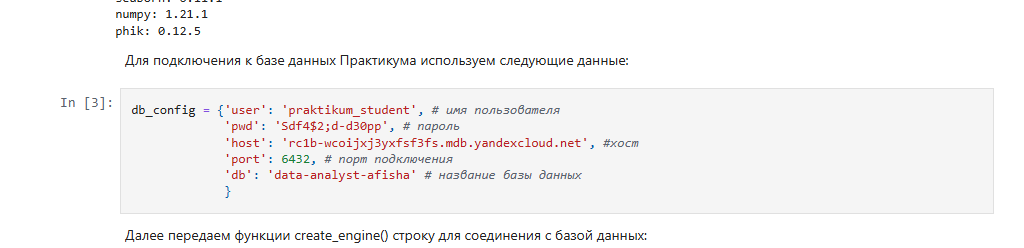    

Все параметры подключения - это приватная информация, которую нельзя выставлять в общественное обозрение.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Это я понял. Постараюсь расписать подробнее, как я понимаю твои слова:

1. Если я делаю проект не локально (я вот эту тетрабку просто в браузере создаю), такой тип подключения использовать нельзя - Jupiter просто не поймет, откуда ему брать данные для подключения, и подключение не произведется;
2. А вот если делать проект локально, то стоит переформатировать подключение на скрытое - с теми данными, которые хранятся в .env файле.
    
В связи с этим, я создал 2 версии тетрадки:
   
1. На платформе - содержит стандартный тип подключения (с открытыми данными, записанными в df_config) и закоммиченным подключением через dotenv;
2. В Гите - с убранными ячейками классического подключения и использованием dotenv.
    
Если я что-то недопонял - напиши, пожалуйста.
    
</div>

### 6. Финализация проекта и публикация в Git

ССылка на проект в GitHub:

**https://github.com/VitAksarin/Module_2_Project**

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> В репозитории размещены файл с проектом и зависимостями.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Можно было бы также добавить `README.md` и отразить там итоговый вывод.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Должен быть также файл `.gitignore`, где будет указан `.env` файл с параметрами подключения к базе данных.
    
В версии, которую ты заливаешь на `GitHub`, не стоит оставлять параметры подключения в явном виде - это может привести к несанкционированному доступу к данным, что чревато их потереей или изменением. Лучшее решение - локально создать `.env` файл, из которого с помощью `os` эти параметры подключения передаются в код. А файл `.gitignore` поможет не отслеживать этот файл для репозитория.
    
Файл `.env` может выглядеть так:

```python
DB_NAME="..."
DB_HOST="..."
DB_PORT="..."
DB_USER="..."
DB_PASSWORD="..."
```
    
В самом проекте мы можем обращаться к сохраненным параметрам с помощью библиотеки `dotenv`, чтобы загрузить переменные окружения, и `os`, чтобы обратиться к ним:
    
```python
import os
import dotenv
    
load_dotenv() # автоматически ищет .env в текущей директории
    
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
)
```

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Тут актуально.
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
у меня не сохранилась последняя версия проекта, в которой я написал коммент к этой части... Прикладываю ее сюда:
    
    Файл .gitignore сейчас вроде подтянулся.
    
Насчет коннекта через .env-файл: он у меня тоже есть, в него записаны те же данные, что здесь в кодовой ячкейке 3 в том формате, в котором они написаны в твоей рекомендации. Но если я вставлю в проект подключение к библиотекам dotenv и os, то у меня все перестанет работать... Я что-то делаю не так?..
    
Сейчас оно вставлено коммитом в 5й ячейке - помоги пожалуйста разобраться, как мне правильно подключаться к базе...
    
На всякий случай, вот содержание моего локального файла .env:

DB_USER=praktikum_student
    
DB_PASSWORD=Sdf4$2;d-d30pp

DB_HOST=rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net

DB_PORT=6432

DB_NAME=data-analyst-afisha  

</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Я, к сожалению, не могу сказать конкретно, не видя саму ошибку, но в целом сам код написан верно. Возможно, ты не установил нужные зависимости в окружение платформы, и код падает из-за этого. Ну и, конечно, сам `env` файл тоже должен быть в досягаемости скрипта.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Подскажи, пожалуйста, после второго рассмотрения у тебя же были замечания только к выводу и загрузке файлов, верно? Не пррсмотрел ли я каких-то вещей по невнимательности...
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Ничего не пропустил.

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту.

Виталий, проект получился на довольно хорошем уровне - отличная работа над проектом, молодец!

Мне нравится твой аналитический подход к выполнению проекта, ты соблюдаешь структуру работы, выполняешь её последовательно - это очень хорошо! Шаги проекта выполнены по порядку согласно плану проекта, нет смысловых и структурных ям. Важно, что не забываешь про выводы.
    
Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.
    
Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)
    
Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.
    
Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)
    
Жду твой проект на повторном ревью. До встречи:)